In [1]:
import os
import re
import PIL
import tarfile
import numpy as np
from datetime import datetime
from shutil import copy as copy_file
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image, display
from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
# Constants

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
imgs_folder_path = "/content/drive/My Drive/content/UTKFace/"

In [4]:
%%time
# This cell takes approx. "49.3 sec" to execute
exp_count = 0
for _rootdir, _, _files in tqdm(os.walk('/content/drive/My Drive/content/UTKFace')):
  for _file in _files:
    try: # Move all files(face images) into single folder named `all`
      os.rename(os.path.join(_rootdir, _file),os.path.join(imgs_folder_path, _file))
    except:  # If any error, continue
      exp_count+=1
      continue
print("Exceptions encountered: {}".format(exp_count))

<timed exec>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

Exceptions encountered: 0
CPU times: user 80.1 ms, sys: 14.2 ms, total: 94.3 ms
Wall time: 825 ms


In [5]:
print('Number of images: {}'.format(len(os.listdir(imgs_folder_path))))

Number of images: 142


In [6]:
%%time
# This cell takes approx. "1min 10s" mins to execute
for _file in tqdm(os.listdir(imgs_folder_path)):
  try:
    # Example:- 23300_1962-06-19_2011.jpg --> Split: ["23300", "1964-06-19", "2011.jpg"]
    file_name = _file.split("_")
    # Date of birth of the person
    begin_date = datetime.strptime(file_name[1], '%Y-%m-%d')
    # The year the picture was taken - 2011 + assuming a mid-year date of month=7 & day=1 for when the photo was taken.
    end_date = datetime(year=int(file_name[2][:4]), month=7, day=1)
    age = end_date.year - begin_date.year
    if age >= 1 and age < 100: # Select only people with age in the range [10,100)
      # Rename face images file names with age
      os.rename(os.path.join(imgs_folder_path, _file), os.path.join(imgs_folder_path, str(age) + "_" + file_name[0] + '.jpg'))
  except:
      # If any error, do nothing or add specific handling for the error
      pass


<timed exec>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/142 [00:00<?, ?it/s]

CPU times: user 30.3 ms, sys: 1.63 ms, total: 32 ms
Wall time: 118 ms


In [7]:

print('Number of images: {}'.format(len(os.listdir(imgs_folder_path))))

Number of images: 142



 ===== 	Age: 20	 =====


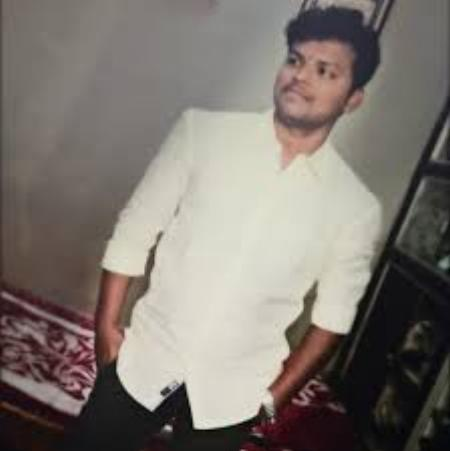


 ===== 	Age: 21	 =====


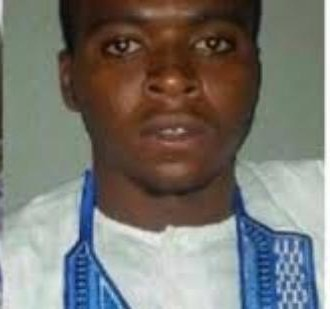


 ===== 	Age: 16	 =====


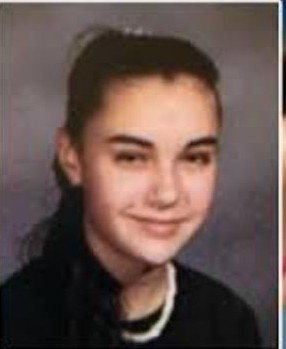


 ===== 	Age: 20	 =====


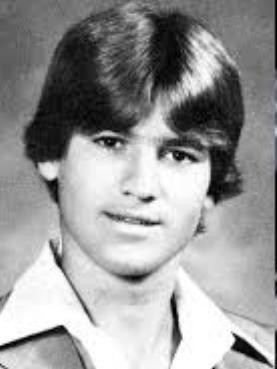


 ===== 	Age: 21	 =====


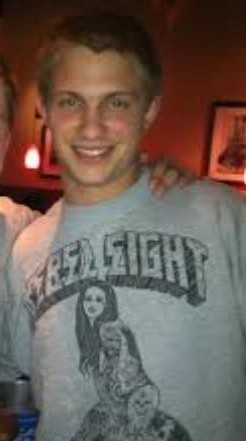


 ===== 	Age: 20	 =====


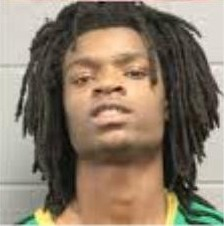


 ===== 	Age: 13	 =====


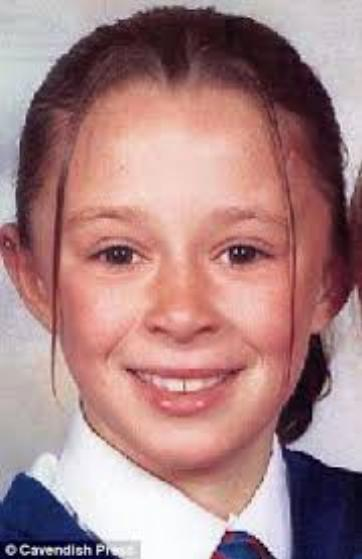


 ===== 	Age: 21	 =====


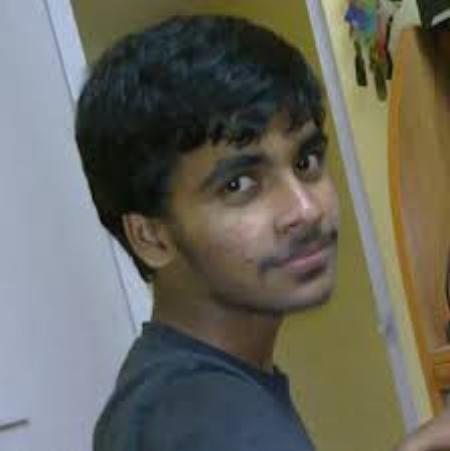


 ===== 	Age: 6	 =====


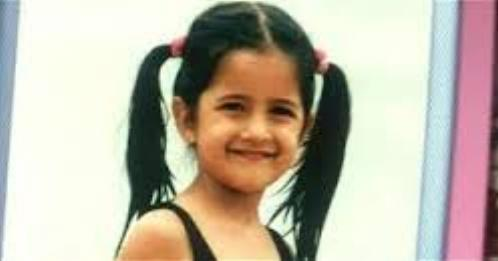


 ===== 	Age: 20	 =====


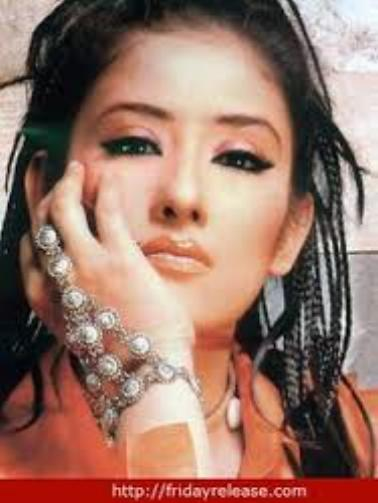

In [8]:

num_samples = 10
random_choice = list(np.random.choice(os.listdir(imgs_folder_path),num_samples))
samples = []
for choice in random_choice:
  space = '='*5
  print('\n',space,'\tAge: {}\t'.format(choice.split('_')[0]),space)
  display(Image(filename=os.path.join(imgs_folder_path,choice), width=200, height=200))

In [9]:
epochs = 2
batch_size = 32
n_models = 3 # Number of VGG19 models in the ensemble
validation_size = 0.5

In [10]:

image_paths_all = os.listdir(imgs_folder_path) # all images
image_paths_train = image_paths_all[:int(len(image_paths_all)*validation_size)] # 50% train
image_paths_val = image_paths_all[int(len(image_paths_all)*validation_size):] # 50% validation
print("Training on {} images".format(len(image_paths_train)))
print("Validating on {} images".format(len(image_paths_val)))

Training on 71 images
Validating on 71 images


In [11]:
# Preprocessing image before feeding to model
def preprocess(img_paths):
  images = []
  labels = []
  for img_path in img_paths:
    image = load_img(os.path.join(imgs_folder_path,img_path), target_size=(224, 224)) # Load image
    image = img_to_array(image) # Convert to numpy array
    image = preprocess_input(image) # Preprocess image as required by VGG19 model
    if(image.shape!=(224,224,3)):
      continue
    images.append(image)
    labels.append(float(img_path.split('_')[0])) # Extract label from image filename
  return np.concatenate([images]), np.array(labels).reshape(len(labels),1)
# Generator for batch training
def batch_generator(img_paths, batch_size=16, seed=1):
  np.random.seed(seed)
  np.random.shuffle(img_paths) # Shuffle before use
  i=0
  while True:
    if(i>=len(img_paths)): # Resetting generator
      i=0
    images, labels = preprocess(img_paths[i:i+batch_size])
    i += batch_size
    yield images, labels


In [12]:
def get_model(train_last_layers=4):
  base_model = VGG19(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  # Freeze the layers except the last `train_last_layers` layers
  for layer in base_model.layers[:-train_last_layers]:
    layer.trainable = False
  # Check the trainable status of the individual layers
  top_model = Flatten()(base_model.output)
  top_model = Dense(1, activation='relu')(top_model)
  model = Model(inputs=base_model.inputs, outputs=top_model)
  model.compile(optimizer='Adam',loss='mean_absolute_error')
  return model

In [13]:
# for layer in model.layers:
#     print(layer, layer.trainable)

In [14]:
#!rm -r model_data/Model\ 1

# model.summary()

rm: cannot remove 'model_data/Model 1': No such file or directory


In [17]:

base_directory='model_data'
if not os.path.exists(base_directory):
  os.makedirs(base_directory)

for model_number in range(n_models):
  model = None
  name = 'Model '+str(model_number+1)
  print("\n\t==>",name)
  generator_train = batch_generator(image_paths_train, batch_size=batch_size, seed=model_number+1)
  generator_val = batch_generator(image_paths_val, batch_size=batch_size, seed=model_number+1)
  base_path = os.path.join('model_data',name)
  if(os.path.exists(base_path)):
    raise NameError('Directory {} already exists. Please delete it first, manually.'.format(base_path))
  os.mkdir(base_path)
  checkpoint = ModelCheckpoint(filepath=os.path.join(base_path,'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'),
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')
  callbacks = [checkpoint]
  model = get_model(train_last_layers=1)
  model.fit(generator_train,
    epochs=epochs,
    steps_per_epoch=len(image_paths_train)//batch_size,
    validation_data=generator_val,
    validation_steps=len(image_paths_val)//batch_size,
    callbacks=callbacks,
    verbose=1)




	==> Model 1
80134624/80134624 [==============================] - 1s 0us/step
Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 13.1055 
Epoch 1: val_loss improved from inf to 9.67013, saving model to model_data/Model 1/epoch-01_loss-13.1055_val_loss-9.6701.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 87s 65s/step - loss: 13.1055 - val_loss: 9.6701
Epoch 2/2
2/2 [==============================] - ETA: 0s - loss: 13.7553
Epoch 2: val_loss did not improve from 9.67013
2/2 [==============================] - 52s 47s/step - loss: 13.7553 - val_loss: 11.7026

	==> Model 2
Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 11.9091 
Epoch 1: val_loss improved from inf to 9.85462, saving model to model_data/Model 2/epoch-01_loss-11.9091_val_loss-9.8546.h5
2/2 [==============================] - 89s 65s/step - loss: 11.9091 - val_loss: 9.8546
Epoch 2/2
2/2 [==============================] - ETA: 0s - loss: 13.1403
Epoch 2: val_loss improved from 9.85462 to 7.27271, saving model to model_data/Model 2/epoch-02_loss-13.1403_val_loss-7.2727.h5
2/2 [==============================] - 51s 47s/step - loss: 13.1403 - val_loss: 7.2727

	==> Model 3
Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 12.9644 
Epoch 1: val_loss improved fro

In [18]:
# Load all models for ensembling
ensemble_models = {}
for model_number in range(n_models):
  name = 'Model '+str(model_number+1)
  base_path = os.path.join('model_data',name)
  # Find the last checkpoint for each model
  model_checkpoints = os.listdir(base_path)
  _list = [(int(re.findall("\d{1,3}",model_ckpt)[0]),model_ckpt) for model_ckpt in model_checkpoints]
  if(len(_list)==0):
    raise ValueError('No checkpoints found for {}'.format(name))
  sorted(_list)
  model_file = _list[0][1]
  # Load the model
  model = load_model(os.path.join(base_path,model_file))
  # Append model to the ensemble
  ensemble_models[name] = model


1/1 [==============================] - 1s 706ms/step
 > True Age : 18
 > Predicted Age by Model 1 : 27.5798
 > Predicted Age by Model 2 : 19.0819
 > Predicted Age by Model 3 : 23.2129
 > Predicted Age by Ensembling : 23.2916


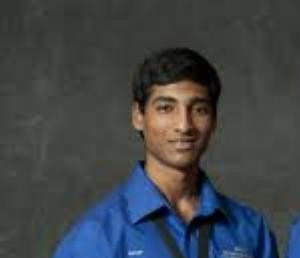

In [19]:

# Test on a random image from validation set
random_choice = list(np.random.choice(image_paths_val,1)) # Choose a random image
test_image, _ = preprocess(random_choice) # Preprocess image
predictions = {}
for model_name,model in ensemble_models.items():
  prediction = model.predict(test_image)
  predictions[model_name] = prediction
print(' > True Age : {}'.format(random_choice[0].split('_')[0]))
ensemble_avg_prediction = 0
for model_name,prediction in predictions.items():
  print(' > Predicted Age by {0} : {1:.4f}'.format(model_name,prediction[0][0]))
  ensemble_avg_prediction = ensemble_avg_prediction + prediction[0][0]
print(' > Predicted Age by Ensembling : {0:.4f}'.format(ensemble_avg_prediction/n_models))
display(Image(filename=os.path.join(imgs_folder_path,random_choice[0]), width=200, height=200))

1/1 [==============================] - 1s 589ms/step

Image: 20_1_3_20170119150812423.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 46.8749
 > Predicted Age by Model 2 : 26.0763
 > Predicted Age by Model 3 : 20.3319
 > Predicted Age by Ensembling : 31.0944


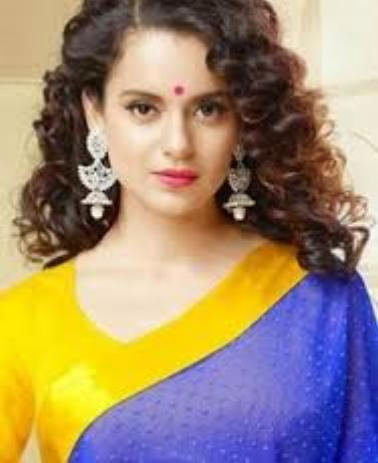

1/1 [==============================] - 1s 588ms/step

Image: 21_0_1_20170116010312874.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.6152
 > Predicted Age by Model 2 : 18.4527
 > Predicted Age by Model 3 : 19.1265
 > Predicted Age by Ensembling : 19.3981


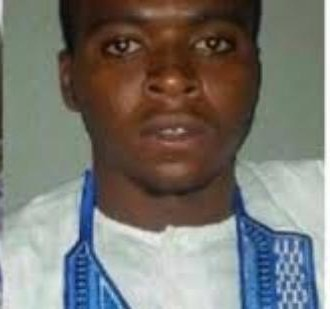

1/1 [==============================] - 1s 593ms/step

Image: 18_0_1_20170120134900190.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 16.2581
 > Predicted Age by Model 2 : 15.1072
 > Predicted Age by Model 3 : 23.3555
 > Predicted Age by Ensembling : 18.2402


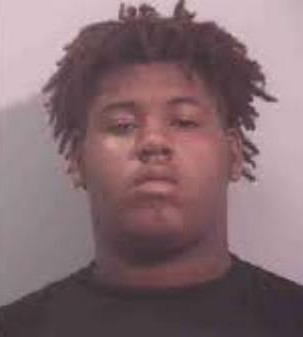

1/1 [==============================] - 1s 573ms/step

Image: 20_1_1_20170116003433569.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 24.3273
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 14.7755
 > Predicted Age by Ensembling : 13.0343


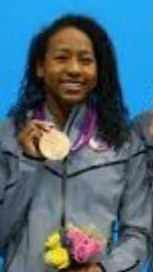

1/1 [==============================] - 1s 571ms/step

Image: 20_1_0_20170116214335363.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 25.9327
 > Predicted Age by Model 2 : 32.1447
 > Predicted Age by Model 3 : 11.5665
 > Predicted Age by Ensembling : 23.2146


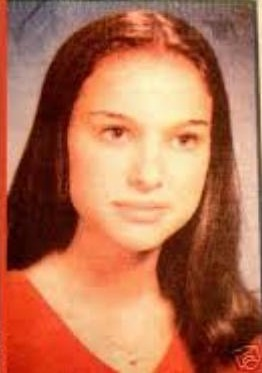

1/1 [==============================] - 1s 994ms/step

Image: 7_0_3_20170119144311624.jpg
 > True Age : 7
 > Predicted Age by Model 1 : 29.4703
 > Predicted Age by Model 2 : 12.6428
 > Predicted Age by Model 3 : 30.8832
 > Predicted Age by Ensembling : 24.3321


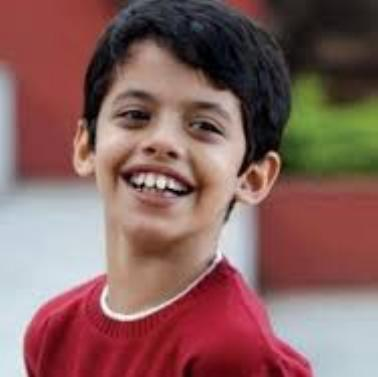

1/1 [==============================] - 1s 578ms/step

Image: 17_0_0_20170116221917954.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 29.7642
 > Predicted Age by Model 2 : 13.2104
 > Predicted Age by Model 3 : 12.1768
 > Predicted Age by Ensembling : 18.3838


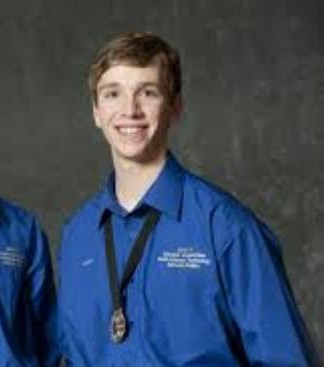

1/1 [==============================] - 1s 576ms/step

Image: 21_0_1_20170116214205175.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 33.7201
 > Predicted Age by Model 2 : 18.4734
 > Predicted Age by Model 3 : 22.0519
 > Predicted Age by Ensembling : 24.7485


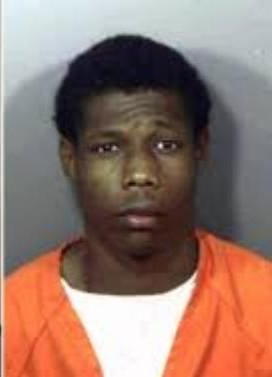

1/1 [==============================] - 1s 570ms/step

Image: 20_1_3_20170119150812423.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 46.8749
 > Predicted Age by Model 2 : 26.0763
 > Predicted Age by Model 3 : 20.3319
 > Predicted Age by Ensembling : 31.0944


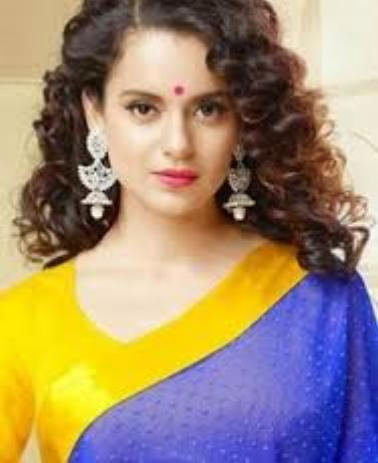

1/1 [==============================] - 1s 572ms/step

Image: 7_1_1_20170116225209209.jpg
 > True Age : 7
 > Predicted Age by Model 1 : 8.0441
 > Predicted Age by Model 2 : 20.6632
 > Predicted Age by Model 3 : 20.1314
 > Predicted Age by Ensembling : 16.2796


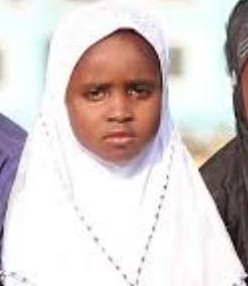

1/1 [==============================] - 1s 606ms/step

Image: 5_1_3_20170119154358954.jpg
 > True Age : 5
 > Predicted Age by Model 1 : 28.5338
 > Predicted Age by Model 2 : 3.2597
 > Predicted Age by Model 3 : 9.1678
 > Predicted Age by Ensembling : 13.6538


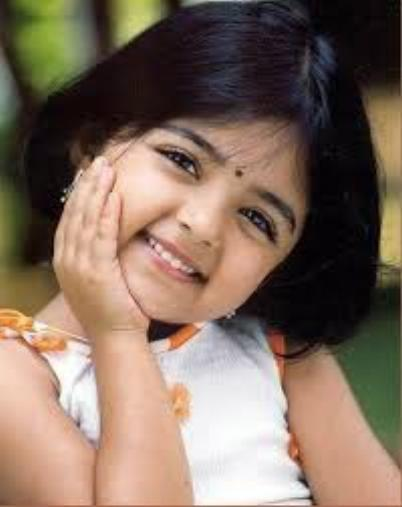

1/1 [==============================] - 1s 1s/step

Image: 21_0_1_20170115231442487.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.0312
 > Predicted Age by Model 2 : 22.8215
 > Predicted Age by Model 3 : 18.8073
 > Predicted Age by Ensembling : 20.5533


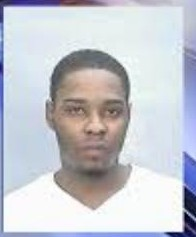

1/1 [==============================] - 1s 811ms/step

Image: 15_1_1_20170116164052068.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 19.9606
 > Predicted Age by Model 2 : 16.3785
 > Predicted Age by Model 3 : 39.9754
 > Predicted Age by Ensembling : 25.4382


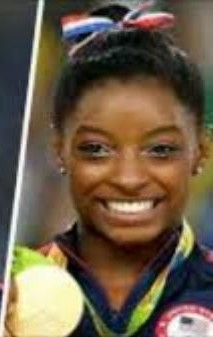

1/1 [==============================] - 1s 590ms/step

Image: 18_1_0_20170117133441179.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 25.6188
 > Predicted Age by Model 2 : 12.7404
 > Predicted Age by Model 3 : 13.3092
 > Predicted Age by Ensembling : 17.2228


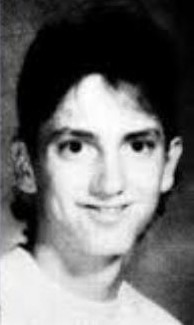

1/1 [==============================] - 1s 593ms/step

Image: 21_1_1_20170116175832136.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 37.3818
 > Predicted Age by Model 2 : 2.5627
 > Predicted Age by Model 3 : 19.6331
 > Predicted Age by Ensembling : 19.8592


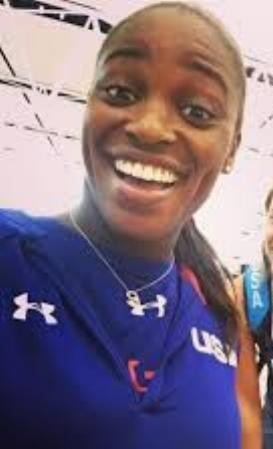

1/1 [==============================] - 1s 589ms/step

Image: 16_0_1_20170120134502877.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.4831
 > Predicted Age by Model 2 : 3.1142
 > Predicted Age by Model 3 : 28.7357
 > Predicted Age by Ensembling : 23.1110


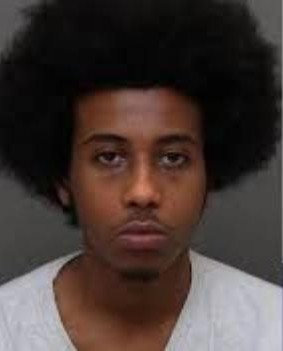

1/1 [==============================] - 1s 600ms/step

Image: 20_1_3_20170119150812423.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 46.8749
 > Predicted Age by Model 2 : 26.0763
 > Predicted Age by Model 3 : 20.3319
 > Predicted Age by Ensembling : 31.0944


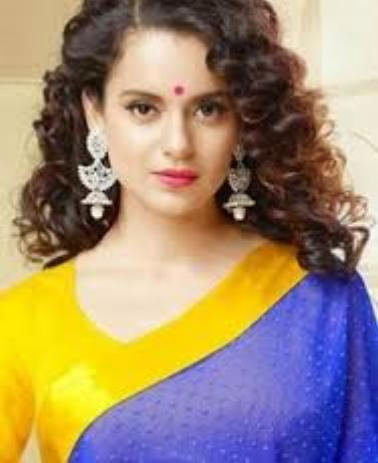

1/1 [==============================] - 1s 586ms/step

Image: 10_0_0_20170116201102149.jpg
 > True Age : 10
 > Predicted Age by Model 1 : 5.3661
 > Predicted Age by Model 2 : 8.2287
 > Predicted Age by Model 3 : 21.5827
 > Predicted Age by Ensembling : 11.7259


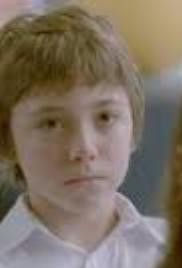

1/1 [==============================] - 1s 959ms/step

Image: 18_0_1_20170120134900190.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 16.2581
 > Predicted Age by Model 2 : 15.1072
 > Predicted Age by Model 3 : 23.3555
 > Predicted Age by Ensembling : 18.2402


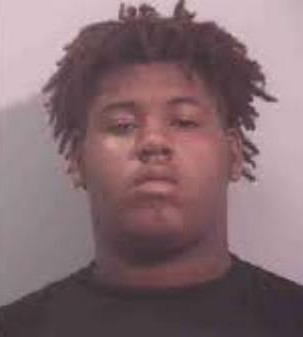

1/1 [==============================] - 1s 590ms/step

Image: 17_0_1_20170116205618568.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 18.0350
 > Predicted Age by Model 2 : 15.8139
 > Predicted Age by Model 3 : 6.7273
 > Predicted Age by Ensembling : 13.5254


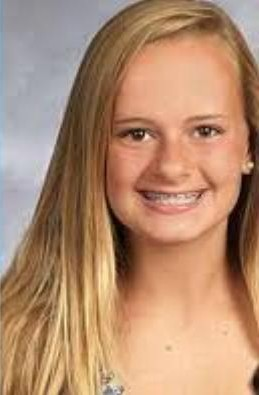

1/1 [==============================] - 1s 586ms/step

Image: 20_0_3_20170119150802863.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 21.2913
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 15.8928
 > Predicted Age by Ensembling : 12.3947


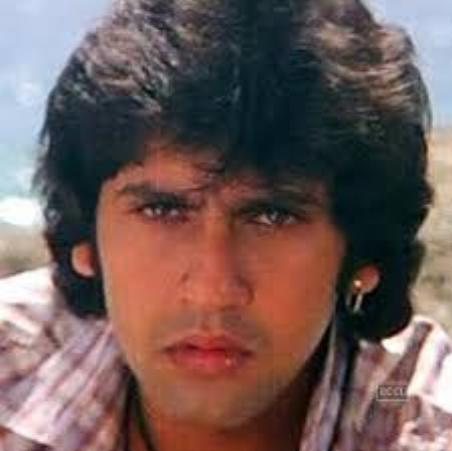

1/1 [==============================] - 1s 590ms/step

Image: 21_0_0_20170120134243735.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.9467
 > Predicted Age by Model 2 : 3.3399
 > Predicted Age by Model 3 : 5.6197
 > Predicted Age by Ensembling : 9.9688


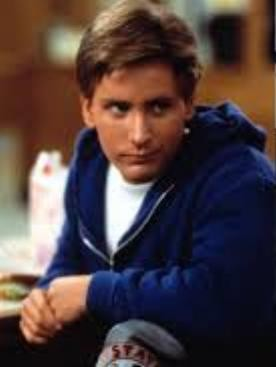

1/1 [==============================] - 1s 575ms/step

Image: 19_1_0_20170119145731470.jpg
 > True Age : 19
 > Predicted Age by Model 1 : 28.1471
 > Predicted Age by Model 2 : 19.6042
 > Predicted Age by Model 3 : 12.1846
 > Predicted Age by Ensembling : 19.9786


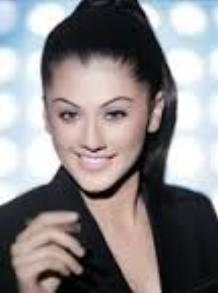

1/1 [==============================] - 1s 571ms/step

Image: 20_1_0_20170119153738075.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 42.1547
 > Predicted Age by Model 2 : 14.1191
 > Predicted Age by Model 3 : 3.3926
 > Predicted Age by Ensembling : 19.8888


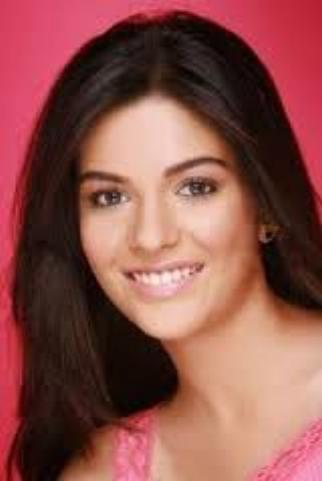

1/1 [==============================] - 1s 1s/step

Image: 21_0_1_20170116214205175.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 33.7201
 > Predicted Age by Model 2 : 18.4734
 > Predicted Age by Model 3 : 22.0519
 > Predicted Age by Ensembling : 24.7485


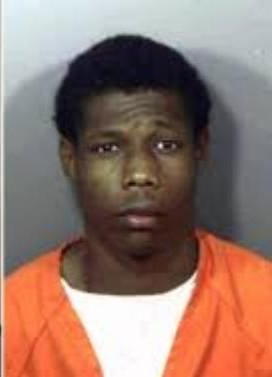

1/1 [==============================] - 1s 608ms/step

Image: 21_0_1_20170116214205175.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 33.7201
 > Predicted Age by Model 2 : 18.4734
 > Predicted Age by Model 3 : 22.0519
 > Predicted Age by Ensembling : 24.7485


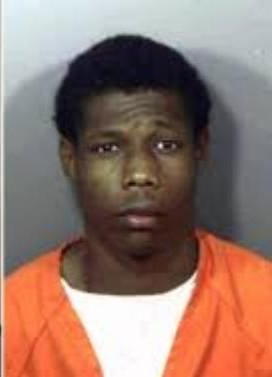

1/1 [==============================] - 1s 573ms/step

Image: 11_1_0_20170117133441179.jpg
 > True Age : 11
 > Predicted Age by Model 1 : 20.4926
 > Predicted Age by Model 2 : 12.5612
 > Predicted Age by Model 3 : 18.0751
 > Predicted Age by Ensembling : 17.0430


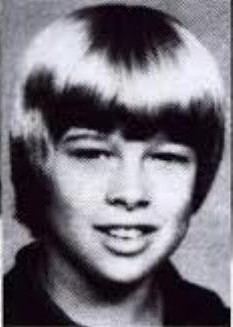

1/1 [==============================] - 1s 571ms/step

Image: 19_0_0_20170119150054894.jpg
 > True Age : 19
 > Predicted Age by Model 1 : 28.8736
 > Predicted Age by Model 2 : 12.2452
 > Predicted Age by Model 3 : 14.9184
 > Predicted Age by Ensembling : 18.6791


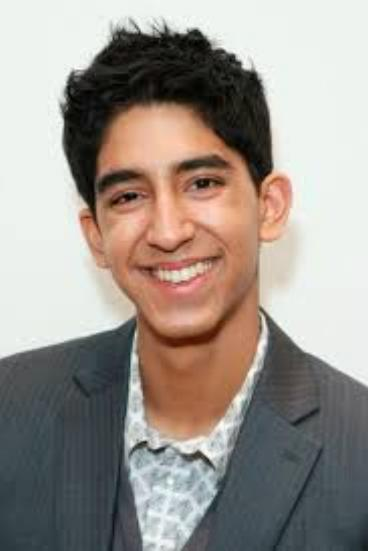

1/1 [==============================] - 1s 580ms/step

Image: 18_1_0_20170117133441179.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 25.6188
 > Predicted Age by Model 2 : 12.7404
 > Predicted Age by Model 3 : 13.3092
 > Predicted Age by Ensembling : 17.2228


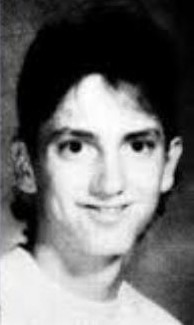

1/1 [==============================] - 1s 575ms/step

Image: 14_0_1_20170116205011065.jpg
 > True Age : 14
 > Predicted Age by Model 1 : 22.8283
 > Predicted Age by Model 2 : 5.8684
 > Predicted Age by Model 3 : 8.3542
 > Predicted Age by Ensembling : 12.3503


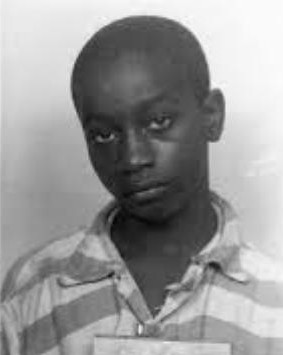

1/1 [==============================] - 1s 794ms/step

Image: 20_1_3_20170119153820321.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 22.4444
 > Predicted Age by Model 2 : 14.2465
 > Predicted Age by Model 3 : 10.9962
 > Predicted Age by Ensembling : 15.8957


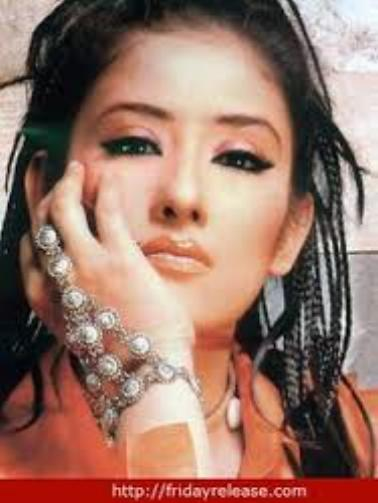

1/1 [==============================] - 1s 924ms/step

Image: 20_1_3_20170119153750257.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 23.6383
 > Predicted Age by Model 2 : 13.2004
 > Predicted Age by Model 3 : 32.1052
 > Predicted Age by Ensembling : 22.9813


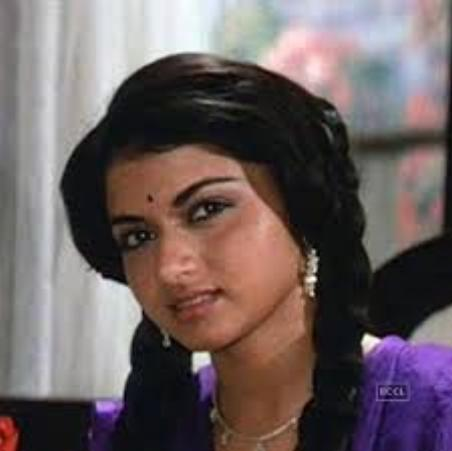

1/1 [==============================] - 1s 570ms/step

Image: 16_1_0_20170117133441179.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 23.5621
 > Predicted Age by Model 2 : 10.6117
 > Predicted Age by Model 3 : 15.4725
 > Predicted Age by Ensembling : 16.5487


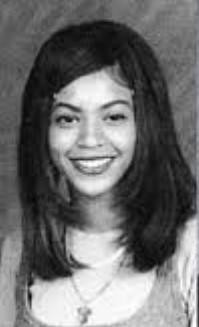

1/1 [==============================] - 1s 577ms/step

Image: 20_1_1_20170116003433569.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 24.3273
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 14.7755
 > Predicted Age by Ensembling : 13.0343


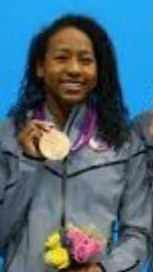

1/1 [==============================] - 1s 586ms/step

Image: 20_1_0_20170116000638538.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 40.8192
 > Predicted Age by Model 2 : 17.6384
 > Predicted Age by Model 3 : 11.6738
 > Predicted Age by Ensembling : 23.3771


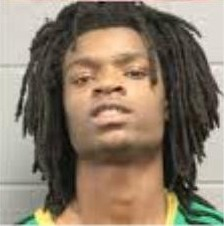

1/1 [==============================] - 1s 583ms/step

Image: 21_1_1_20170116214444631.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 21.3771
 > Predicted Age by Model 2 : 22.0200
 > Predicted Age by Model 3 : 18.4166
 > Predicted Age by Ensembling : 20.6046


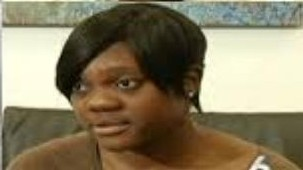

1/1 [==============================] - 1s 594ms/step

Image: 18_1_3_20170119155644533.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 13.1805
 > Predicted Age by Model 2 : 20.8751
 > Predicted Age by Model 3 : 17.4503
 > Predicted Age by Ensembling : 17.1686


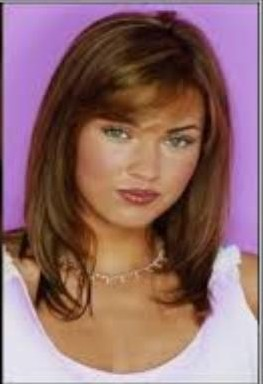

1/1 [==============================] - 1s 1s/step

Image: 20_1_0_20170116214335363.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 25.9327
 > Predicted Age by Model 2 : 32.1447
 > Predicted Age by Model 3 : 11.5665
 > Predicted Age by Ensembling : 23.2146


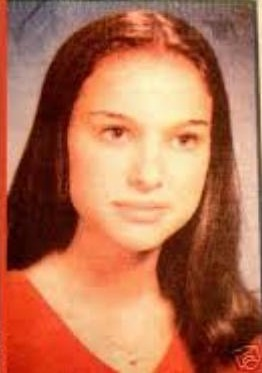

1/1 [==============================] - 1s 570ms/step

Image: 14_0_0_20170116204045849.jpg
 > True Age : 14
 > Predicted Age by Model 1 : 17.0081
 > Predicted Age by Model 2 : 15.9479
 > Predicted Age by Model 3 : 3.4488
 > Predicted Age by Ensembling : 12.1349


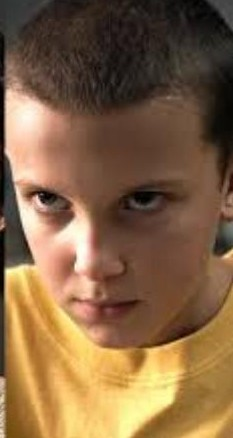

1/1 [==============================] - 1s 583ms/step

Image: 15_1_1_20170116000638538.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 21.2212
 > Predicted Age by Model 2 : 15.3843
 > Predicted Age by Model 3 : 18.5668
 > Predicted Age by Ensembling : 18.3908


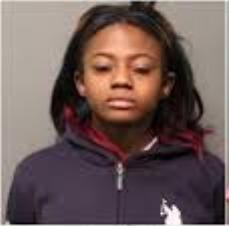

1/1 [==============================] - 1s 585ms/step

Image: 4_1_0_20170116215618294.jpg
 > True Age : 4
 > Predicted Age by Model 1 : 32.7045
 > Predicted Age by Model 2 : 5.7973
 > Predicted Age by Model 3 : 36.3319
 > Predicted Age by Ensembling : 24.9446


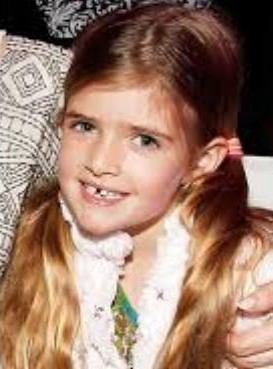

1/1 [==============================] - 1s 585ms/step

Image: 8_1_0_20170117154607954.jpg
 > True Age : 8
 > Predicted Age by Model 1 : 18.3582
 > Predicted Age by Model 2 : 26.1196
 > Predicted Age by Model 3 : 12.4088
 > Predicted Age by Ensembling : 18.9622


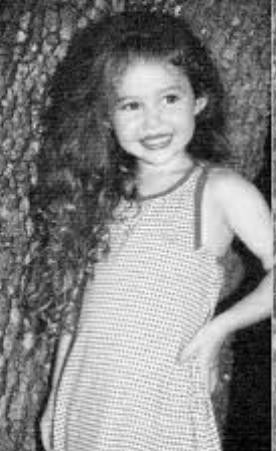

1/1 [==============================] - 1s 592ms/step

Image: 21_1_1_20170116233611534.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 14.0969
 > Predicted Age by Model 2 : 12.0783
 > Predicted Age by Model 3 : 8.7296
 > Predicted Age by Ensembling : 11.6349


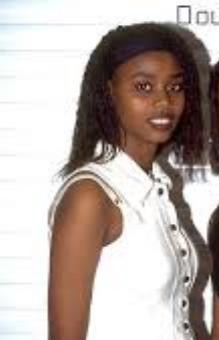

1/1 [==============================] - 1s 913ms/step

Image: 15_1_0_20170116232438243.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 18.4518
 > Predicted Age by Model 2 : 25.5183
 > Predicted Age by Model 3 : 28.6537
 > Predicted Age by Ensembling : 24.2079


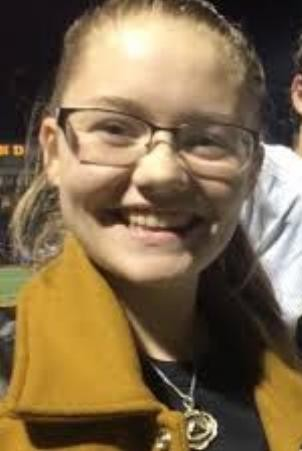

1/1 [==============================] - 1s 942ms/step

Image: 16_0_1_20170120134502877.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.4831
 > Predicted Age by Model 2 : 3.1142
 > Predicted Age by Model 3 : 28.7357
 > Predicted Age by Ensembling : 23.1110


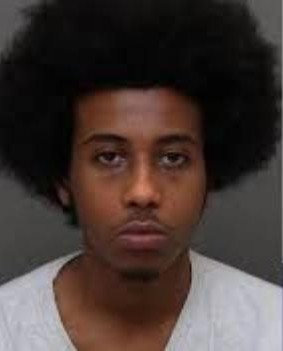

1/1 [==============================] - 1s 588ms/step

Image: 17_0_1_20170116205618568.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 18.0350
 > Predicted Age by Model 2 : 15.8139
 > Predicted Age by Model 3 : 6.7273
 > Predicted Age by Ensembling : 13.5254


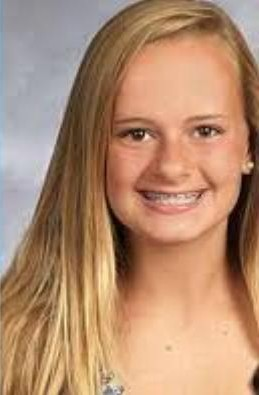

1/1 [==============================] - 1s 591ms/step

Image: 19_0_0_20170119150054894.jpg
 > True Age : 19
 > Predicted Age by Model 1 : 28.8736
 > Predicted Age by Model 2 : 12.2452
 > Predicted Age by Model 3 : 14.9184
 > Predicted Age by Ensembling : 18.6791


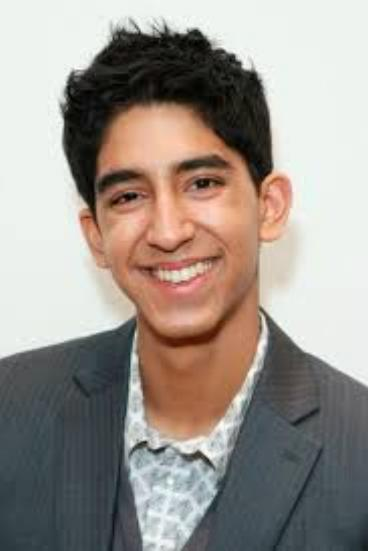

1/1 [==============================] - 1s 587ms/step

Image: 21_1_0_20170120134012302.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 27.7126
 > Predicted Age by Model 2 : 11.5868
 > Predicted Age by Model 3 : 8.2407
 > Predicted Age by Ensembling : 15.8467


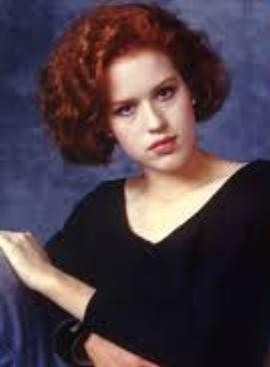

1/1 [==============================] - 1s 577ms/step

Image: 16_0_1_20170116214205175.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 32.2200
 > Predicted Age by Model 2 : 13.7117
 > Predicted Age by Model 3 : 10.9172
 > Predicted Age by Ensembling : 18.9497


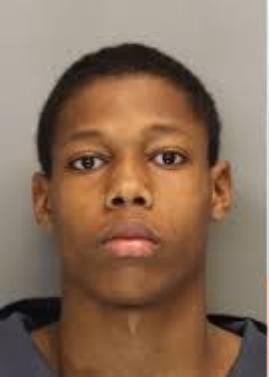

1/1 [==============================] - 1s 570ms/step

Image: 17_0_0_20170117091447979.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 29.7262
 > Predicted Age by Model 2 : 23.1465
 > Predicted Age by Model 3 : 24.0865
 > Predicted Age by Ensembling : 25.6531


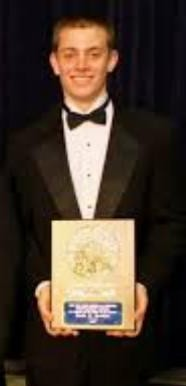

1/1 [==============================] - 1s 1s/step

Image: 14_0_0_20170116204045849.jpg
 > True Age : 14
 > Predicted Age by Model 1 : 17.0081
 > Predicted Age by Model 2 : 15.9479
 > Predicted Age by Model 3 : 3.4488
 > Predicted Age by Ensembling : 12.1349


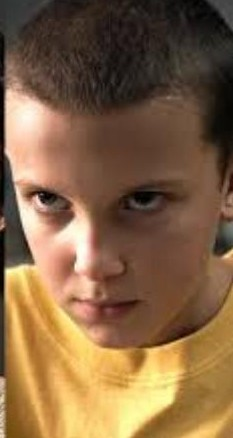

1/1 [==============================] - 1s 728ms/step

Image: 17_0_0_20170117091447979.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 29.7262
 > Predicted Age by Model 2 : 23.1465
 > Predicted Age by Model 3 : 24.0865
 > Predicted Age by Ensembling : 25.6531


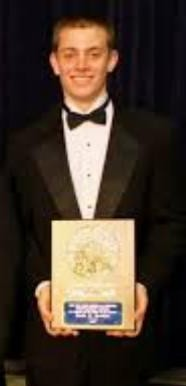

1/1 [==============================] - 1s 590ms/step

Image: 20_1_0_20170119153717575.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 23.9690
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 21.4959
 > Predicted Age by Ensembling : 15.1550


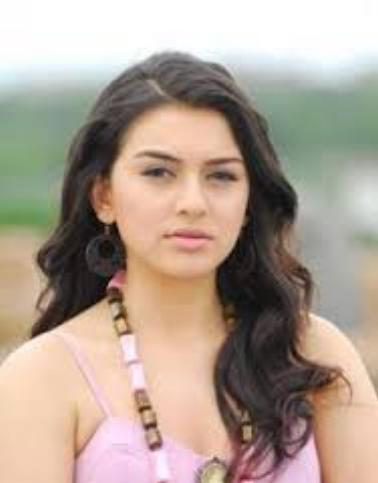

1/1 [==============================] - 1s 584ms/step

Image: 11_1_0_20170117133441179.jpg
 > True Age : 11
 > Predicted Age by Model 1 : 20.4926
 > Predicted Age by Model 2 : 12.5612
 > Predicted Age by Model 3 : 18.0751
 > Predicted Age by Ensembling : 17.0430


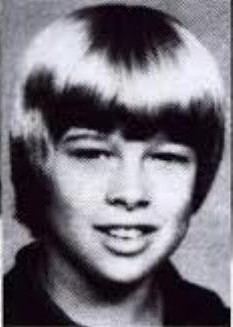

1/1 [==============================] - 1s 591ms/step

Image: 10_0_0_20170116201102149.jpg
 > True Age : 10
 > Predicted Age by Model 1 : 5.3661
 > Predicted Age by Model 2 : 8.2287
 > Predicted Age by Model 3 : 21.5827
 > Predicted Age by Ensembling : 11.7259


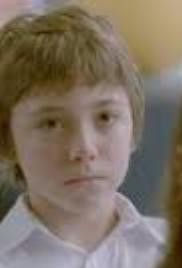

1/1 [==============================] - 1s 590ms/step

Image: 21_0_3_20170119150216454.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 24.8380
 > Predicted Age by Model 2 : 23.9831
 > Predicted Age by Model 3 : 15.1264
 > Predicted Age by Ensembling : 21.3158


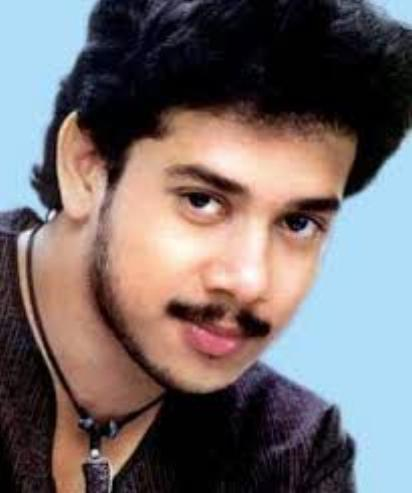

1/1 [==============================] - 1s 1s/step

Image: 14_0_1_20170116205011065.jpg
 > True Age : 14
 > Predicted Age by Model 1 : 22.8283
 > Predicted Age by Model 2 : 5.8684
 > Predicted Age by Model 3 : 8.3542
 > Predicted Age by Ensembling : 12.3503


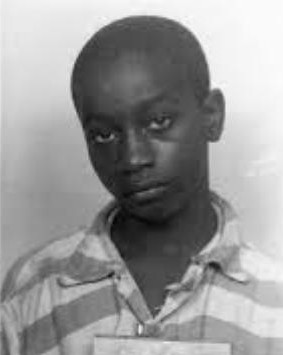

1/1 [==============================] - 1s 1s/step

Image: 17_0_1_20170116205618568.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 18.0350
 > Predicted Age by Model 2 : 15.8139
 > Predicted Age by Model 3 : 6.7273
 > Predicted Age by Ensembling : 13.5254


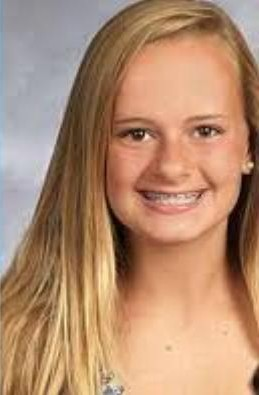

1/1 [==============================] - 1s 596ms/step

Image: 20_1_1_20170116215855605.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 18.5725
 > Predicted Age by Model 2 : 15.8632
 > Predicted Age by Model 3 : 23.0186
 > Predicted Age by Ensembling : 19.1514


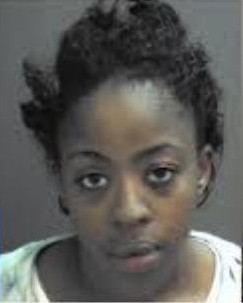

1/1 [==============================] - 1s 572ms/step

Image: 10_0_0_20170116201102149.jpg
 > True Age : 10
 > Predicted Age by Model 1 : 5.3661
 > Predicted Age by Model 2 : 8.2287
 > Predicted Age by Model 3 : 21.5827
 > Predicted Age by Ensembling : 11.7259


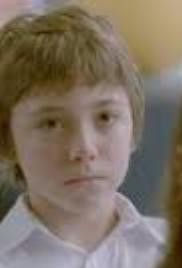

1/1 [==============================] - 1s 579ms/step

Image: 16_0_1_20170120134502877.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.4831
 > Predicted Age by Model 2 : 3.1142
 > Predicted Age by Model 3 : 28.7357
 > Predicted Age by Ensembling : 23.1110


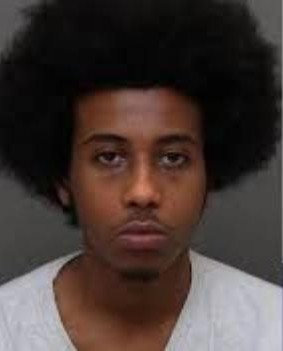

1/1 [==============================] - 1s 573ms/step

Image: 6_0_3_20170119145452429.jpg
 > True Age : 6
 > Predicted Age by Model 1 : 27.2164
 > Predicted Age by Model 2 : 13.0341
 > Predicted Age by Model 3 : 19.9193
 > Predicted Age by Ensembling : 20.0566


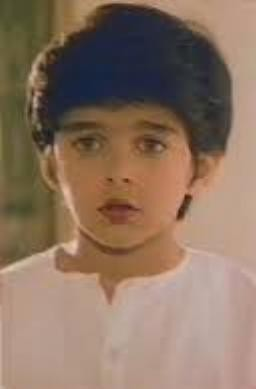

1/1 [==============================] - 1s 573ms/step

Image: 21_0_1_20170116214205175.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 33.7201
 > Predicted Age by Model 2 : 18.4734
 > Predicted Age by Model 3 : 22.0519
 > Predicted Age by Ensembling : 24.7485


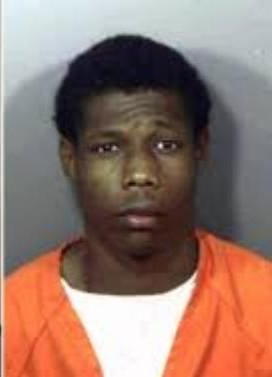

1/1 [==============================] - 1s 1s/step

Image: 17_0_0_20170116221917954.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 29.7642
 > Predicted Age by Model 2 : 13.2104
 > Predicted Age by Model 3 : 12.1768
 > Predicted Age by Ensembling : 18.3838


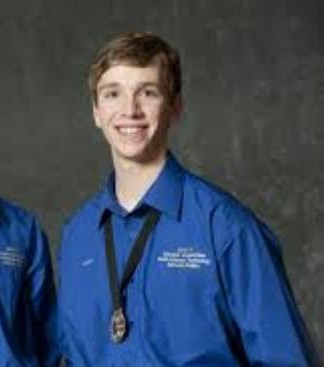

1/1 [==============================] - 1s 581ms/step

Image: 16_1_0_20170116204045849.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.7358
 > Predicted Age by Model 2 : 22.4056
 > Predicted Age by Model 3 : 16.6791
 > Predicted Age by Ensembling : 25.6068


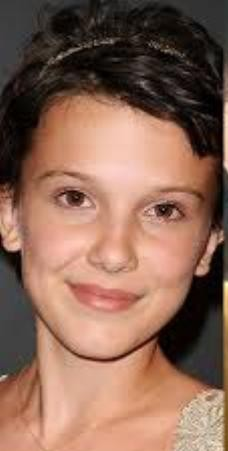

1/1 [==============================] - 1s 578ms/step

Image: 21_0_3_20170119150216454.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 24.8380
 > Predicted Age by Model 2 : 23.9831
 > Predicted Age by Model 3 : 15.1264
 > Predicted Age by Ensembling : 21.3158


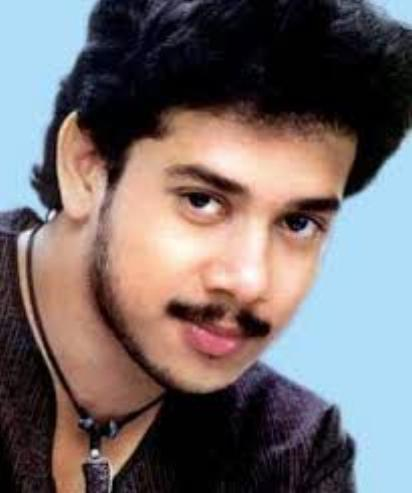

1/1 [==============================] - 1s 574ms/step

Image: 20_1_0_20170119153717575.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 23.9690
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 21.4959
 > Predicted Age by Ensembling : 15.1550


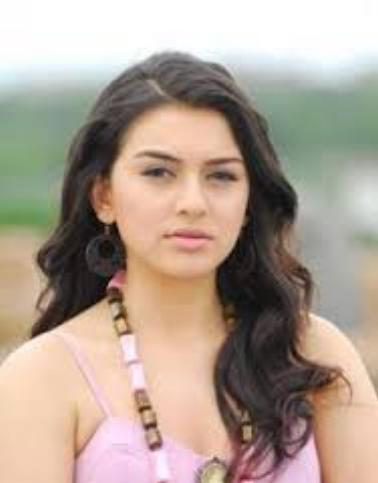

1/1 [==============================] - 1s 572ms/step

Image: 14_0_0_20170116204045849.jpg
 > True Age : 14
 > Predicted Age by Model 1 : 17.0081
 > Predicted Age by Model 2 : 15.9479
 > Predicted Age by Model 3 : 3.4488
 > Predicted Age by Ensembling : 12.1349


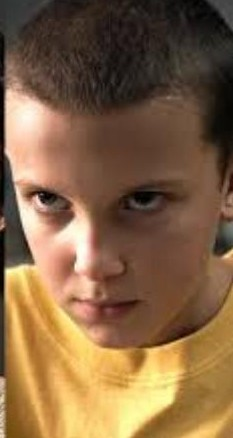

1/1 [==============================] - 1s 578ms/step

Image: 15_1_1_20170116000638538.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 21.2212
 > Predicted Age by Model 2 : 15.3843
 > Predicted Age by Model 3 : 18.5668
 > Predicted Age by Ensembling : 18.3908


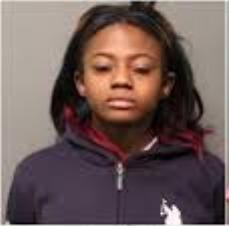

1/1 [==============================] - 1s 879ms/step

Image: 21_0_1_20170116214205175.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 33.7201
 > Predicted Age by Model 2 : 18.4734
 > Predicted Age by Model 3 : 22.0519
 > Predicted Age by Ensembling : 24.7485


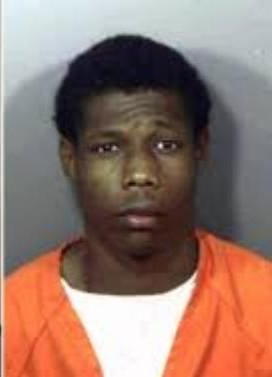

1/1 [==============================] - 1s 945ms/step

Image: 18_0_3_20170116221917954.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 27.5798
 > Predicted Age by Model 2 : 19.0819
 > Predicted Age by Model 3 : 23.2129
 > Predicted Age by Ensembling : 23.2916


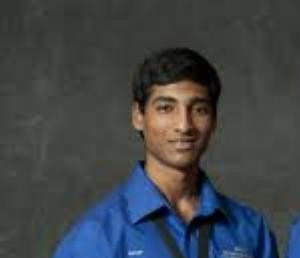

1/1 [==============================] - 1s 681ms/step

Image: 21_1_1_20170116215855605.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 15.6305
 > Predicted Age by Model 2 : 13.2971
 > Predicted Age by Model 3 : 13.5327
 > Predicted Age by Ensembling : 14.1534


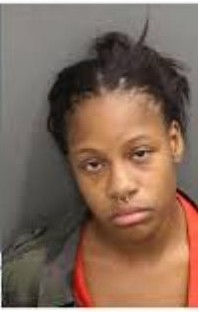

1/1 [==============================] - 1s 577ms/step

Image: 16_0_1_20170120134502877.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.4831
 > Predicted Age by Model 2 : 3.1142
 > Predicted Age by Model 3 : 28.7357
 > Predicted Age by Ensembling : 23.1110


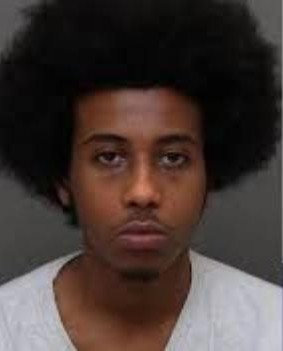

1/1 [==============================] - 1s 575ms/step

Image: 16_0_1_20170116214205175.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 32.2200
 > Predicted Age by Model 2 : 13.7117
 > Predicted Age by Model 3 : 10.9172
 > Predicted Age by Ensembling : 18.9497


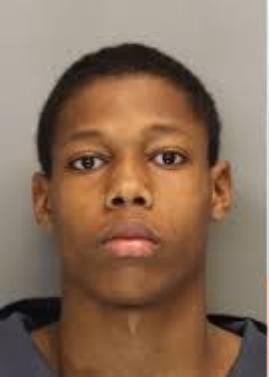

1/1 [==============================] - 1s 790ms/step

Image: 18_1_0_20170117133441179.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 25.6188
 > Predicted Age by Model 2 : 12.7404
 > Predicted Age by Model 3 : 13.3092
 > Predicted Age by Ensembling : 17.2228


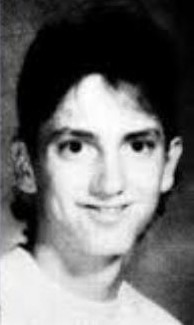

1/1 [==============================] - 1s 1s/step

Image: 17_0_1_20170116205618568.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 18.0350
 > Predicted Age by Model 2 : 15.8139
 > Predicted Age by Model 3 : 6.7273
 > Predicted Age by Ensembling : 13.5254


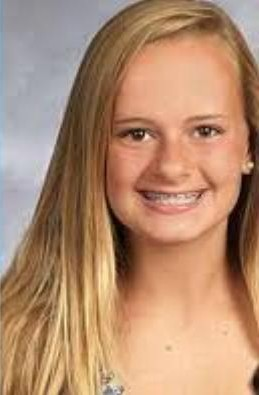

1/1 [==============================] - 1s 573ms/step

Image: 16_0_1_20170120134502877.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.4831
 > Predicted Age by Model 2 : 3.1142
 > Predicted Age by Model 3 : 28.7357
 > Predicted Age by Ensembling : 23.1110


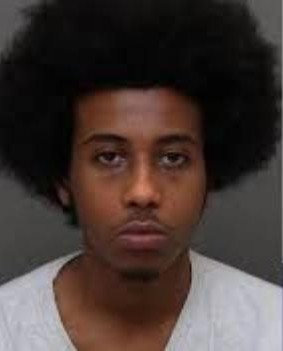

1/1 [==============================] - 1s 587ms/step

Image: 18_0_1_20170120134900190.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 16.2581
 > Predicted Age by Model 2 : 15.1072
 > Predicted Age by Model 3 : 23.3555
 > Predicted Age by Ensembling : 18.2402


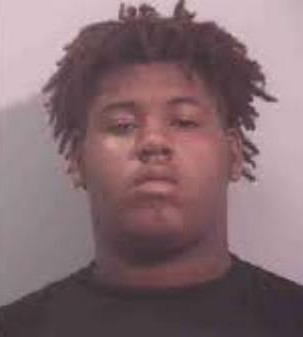

1/1 [==============================] - 1s 574ms/step

Image: 18_1_1_20170116164854853.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 25.9349
 > Predicted Age by Model 2 : 8.3423
 > Predicted Age by Model 3 : 30.7756
 > Predicted Age by Ensembling : 21.6843


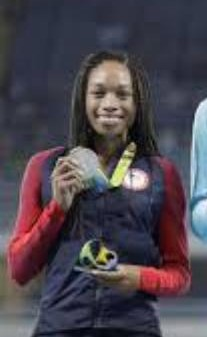

1/1 [==============================] - 1s 575ms/step

Image: 21_0_0_20170120134243735.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.9467
 > Predicted Age by Model 2 : 3.3399
 > Predicted Age by Model 3 : 5.6197
 > Predicted Age by Ensembling : 9.9688


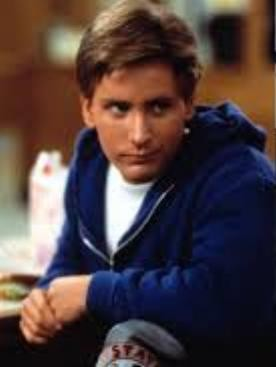

1/1 [==============================] - 1s 589ms/step

Image: 21_1_1_20170116215855605.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 15.6305
 > Predicted Age by Model 2 : 13.2971
 > Predicted Age by Model 3 : 13.5327
 > Predicted Age by Ensembling : 14.1534


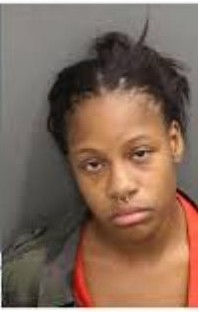

1/1 [==============================] - 1s 997ms/step

Image: 18_1_1_20170116164854853.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 25.9349
 > Predicted Age by Model 2 : 8.3423
 > Predicted Age by Model 3 : 30.7756
 > Predicted Age by Ensembling : 21.6843


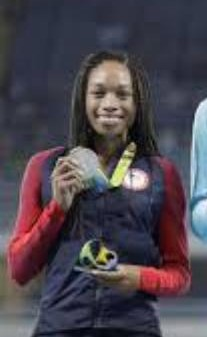

1/1 [==============================] - 1s 837ms/step

Image: 6_0_3_20170119145452429.jpg
 > True Age : 6
 > Predicted Age by Model 1 : 27.2164
 > Predicted Age by Model 2 : 13.0341
 > Predicted Age by Model 3 : 19.9193
 > Predicted Age by Ensembling : 20.0566


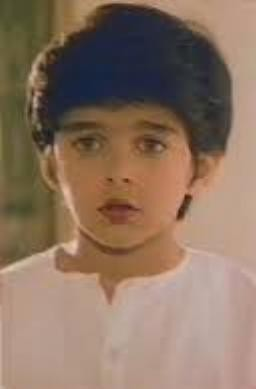

1/1 [==============================] - 1s 573ms/step

Image: 20_1_0_20170119153738075.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 42.1547
 > Predicted Age by Model 2 : 14.1191
 > Predicted Age by Model 3 : 3.3926
 > Predicted Age by Ensembling : 19.8888


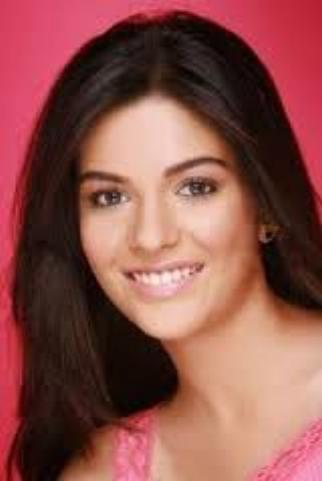

1/1 [==============================] - 1s 574ms/step

Image: 18_1_3_20170119155644533.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 13.1805
 > Predicted Age by Model 2 : 20.8751
 > Predicted Age by Model 3 : 17.4503
 > Predicted Age by Ensembling : 17.1686


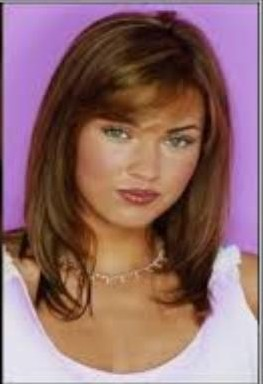

1/1 [==============================] - 1s 578ms/step

Image: 20_1_3_20170119153755113.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 25.8286
 > Predicted Age by Model 2 : 10.3090
 > Predicted Age by Model 3 : 20.5873
 > Predicted Age by Ensembling : 18.9083


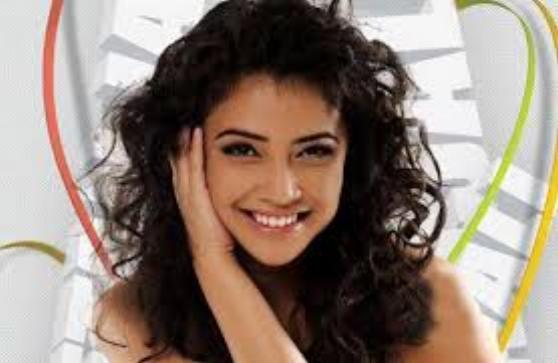

1/1 [==============================] - 1s 577ms/step

Image: 6_0_3_20170119145452429.jpg
 > True Age : 6
 > Predicted Age by Model 1 : 27.2164
 > Predicted Age by Model 2 : 13.0341
 > Predicted Age by Model 3 : 19.9193
 > Predicted Age by Ensembling : 20.0566


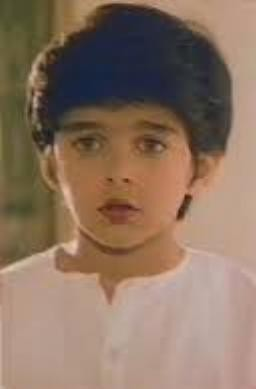

1/1 [==============================] - 1s 665ms/step

Image: 17_0_1_20170116205618568.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 18.0350
 > Predicted Age by Model 2 : 15.8139
 > Predicted Age by Model 3 : 6.7273
 > Predicted Age by Ensembling : 13.5254


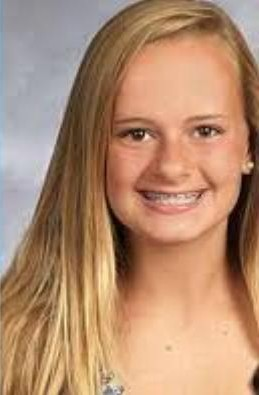

1/1 [==============================] - 1s 941ms/step

Image: 20_0_0_20170116205342932.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 18.2270
 > Predicted Age by Model 2 : 9.6286
 > Predicted Age by Model 3 : 13.8216
 > Predicted Age by Ensembling : 13.8924


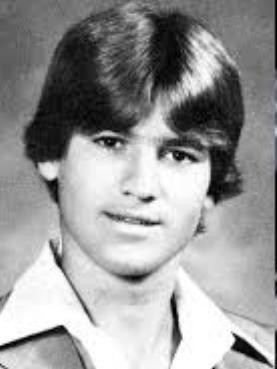

1/1 [==============================] - 1s 590ms/step

Image: 17_0_0_20170116221917954.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 29.7642
 > Predicted Age by Model 2 : 13.2104
 > Predicted Age by Model 3 : 12.1768
 > Predicted Age by Ensembling : 18.3838


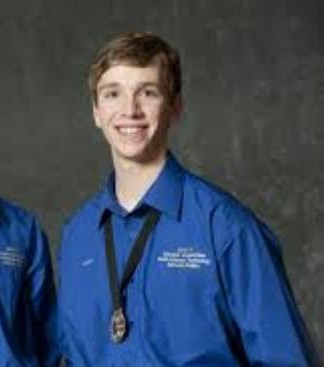

1/1 [==============================] - 1s 591ms/step

Image: 20_0_3_20170119150802863.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 21.2913
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 15.8928
 > Predicted Age by Ensembling : 12.3947


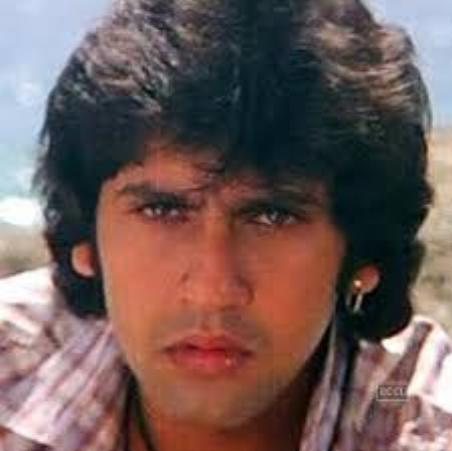

1/1 [==============================] - 1s 591ms/step

Image: 15_1_1_20170116164052068.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 19.9606
 > Predicted Age by Model 2 : 16.3785
 > Predicted Age by Model 3 : 39.9754
 > Predicted Age by Ensembling : 25.4382


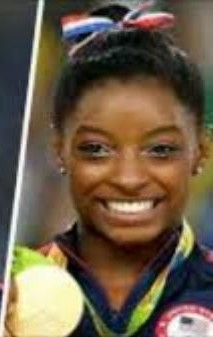

1/1 [==============================] - 1s 597ms/step

Image: 17_1_0_20170116222802508.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 18.0047
 > Predicted Age by Model 2 : 14.6179
 > Predicted Age by Model 3 : 10.7507
 > Predicted Age by Ensembling : 14.4578


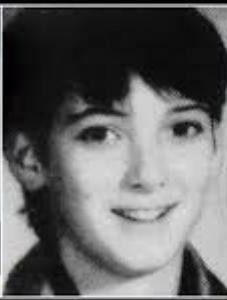

1/1 [==============================] - 1s 620ms/step

Image: 16_1_0_20170119155149354.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 23.8632
 > Predicted Age by Model 2 : 16.1167
 > Predicted Age by Model 3 : 12.8611
 > Predicted Age by Ensembling : 17.6137


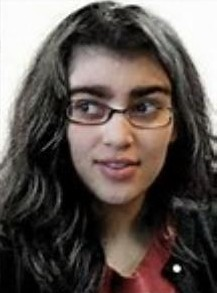

1/1 [==============================] - 1s 995ms/step

Image: 7_0_3_20170119144311624.jpg
 > True Age : 7
 > Predicted Age by Model 1 : 29.4703
 > Predicted Age by Model 2 : 12.6428
 > Predicted Age by Model 3 : 30.8832
 > Predicted Age by Ensembling : 24.3321


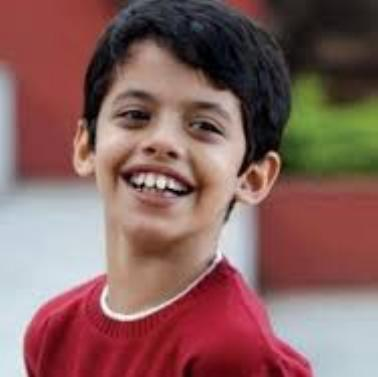

1/1 [==============================] - 1s 573ms/step

Image: 19_1_0_20170119145731470.jpg
 > True Age : 19
 > Predicted Age by Model 1 : 28.1471
 > Predicted Age by Model 2 : 19.6042
 > Predicted Age by Model 3 : 12.1846
 > Predicted Age by Ensembling : 19.9786


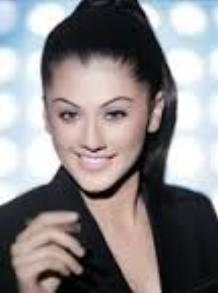

1/1 [==============================] - 1s 576ms/step

Image: 21_0_0_20170120134243735.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.9467
 > Predicted Age by Model 2 : 3.3399
 > Predicted Age by Model 3 : 5.6197
 > Predicted Age by Ensembling : 9.9688


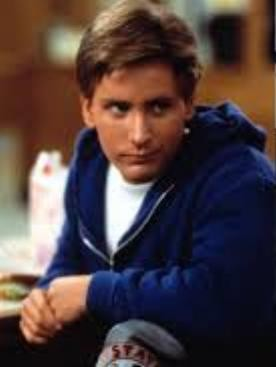

1/1 [==============================] - 1s 580ms/step

Image: 20_1_3_20170119153750257.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 23.6383
 > Predicted Age by Model 2 : 13.2004
 > Predicted Age by Model 3 : 32.1052
 > Predicted Age by Ensembling : 22.9813


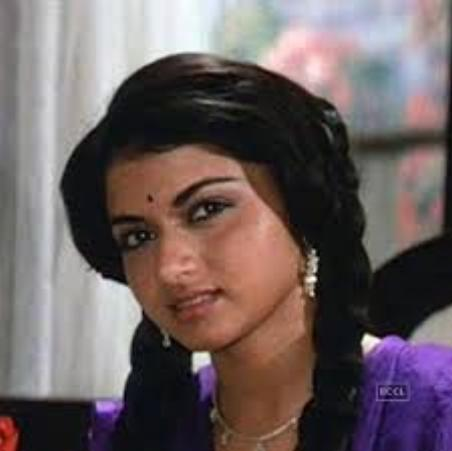

1/1 [==============================] - 1s 587ms/step

Image: 20_1_3_20170119153712943.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 45.1280
 > Predicted Age by Model 2 : 6.6010
 > Predicted Age by Model 3 : 13.3275
 > Predicted Age by Ensembling : 21.6855


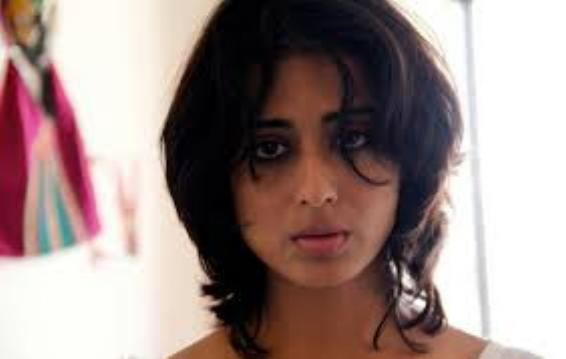

1/1 [==============================] - 1s 588ms/step

Image: 21_1_1_20170117154222282.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 13.1031
 > Predicted Age by Model 2 : 5.9906
 > Predicted Age by Model 3 : 0.0000
 > Predicted Age by Ensembling : 6.3646


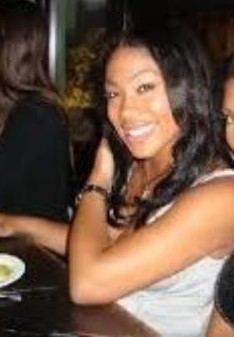

1/1 [==============================] - 1s 1s/step

Image: 21_0_0_20170120134243735.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.9467
 > Predicted Age by Model 2 : 3.3399
 > Predicted Age by Model 3 : 5.6197
 > Predicted Age by Ensembling : 9.9688


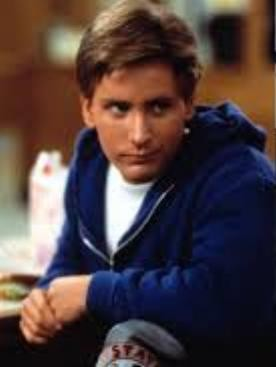

1/1 [==============================] - 1s 589ms/step

Image: 7_1_1_20170116225209209.jpg
 > True Age : 7
 > Predicted Age by Model 1 : 8.0441
 > Predicted Age by Model 2 : 20.6632
 > Predicted Age by Model 3 : 20.1314
 > Predicted Age by Ensembling : 16.2796


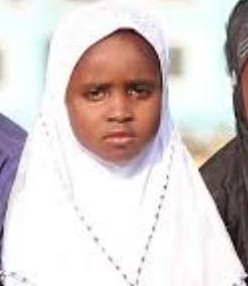

1/1 [==============================] - 1s 580ms/step

Image: 21_1_1_20170116020956813.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 25.5209
 > Predicted Age by Model 2 : 25.6493
 > Predicted Age by Model 3 : 34.0047
 > Predicted Age by Ensembling : 28.3916


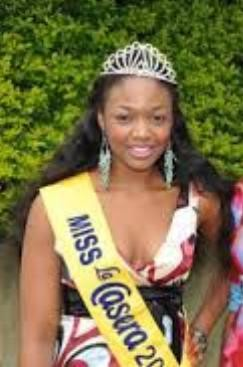

1/1 [==============================] - 1s 583ms/step

Image: 20_1_1_20170116164052068.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 39.4924
 > Predicted Age by Model 2 : 23.9949
 > Predicted Age by Model 3 : 45.7691
 > Predicted Age by Ensembling : 36.4188


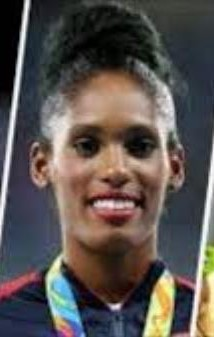

1/1 [==============================] - 1s 582ms/step

Image: 15_1_1_20170116164052068.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 19.9606
 > Predicted Age by Model 2 : 16.3785
 > Predicted Age by Model 3 : 39.9754
 > Predicted Age by Ensembling : 25.4382


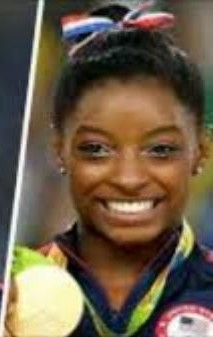

1/1 [==============================] - 1s 581ms/step

Image: 16_1_0_20170117133441179.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 23.5621
 > Predicted Age by Model 2 : 10.6117
 > Predicted Age by Model 3 : 15.4725
 > Predicted Age by Ensembling : 16.5487


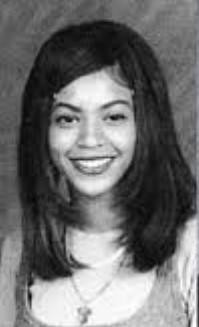

1/1 [==============================] - 1s 1s/step

Image: 21_0_1_20170115231442487.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.0312
 > Predicted Age by Model 2 : 22.8215
 > Predicted Age by Model 3 : 18.8073
 > Predicted Age by Ensembling : 20.5533


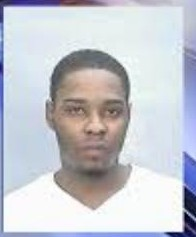

1/1 [==============================] - 1s 600ms/step

Image: 21_1_1_20170117154222282.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 13.1031
 > Predicted Age by Model 2 : 5.9906
 > Predicted Age by Model 3 : 0.0000
 > Predicted Age by Ensembling : 6.3646


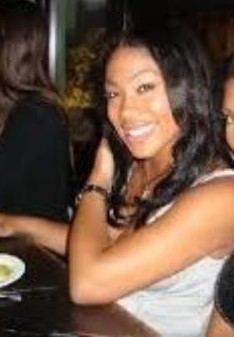

1/1 [==============================] - 1s 593ms/step

Image: 21_1_1_20170116175832136.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 37.3818
 > Predicted Age by Model 2 : 2.5627
 > Predicted Age by Model 3 : 19.6331
 > Predicted Age by Ensembling : 19.8592


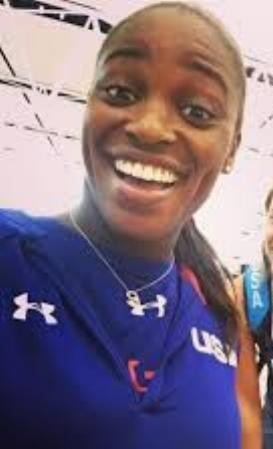

1/1 [==============================] - 1s 592ms/step

Image: 16_1_0_20170116204045849.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.7358
 > Predicted Age by Model 2 : 22.4056
 > Predicted Age by Model 3 : 16.6791
 > Predicted Age by Ensembling : 25.6068


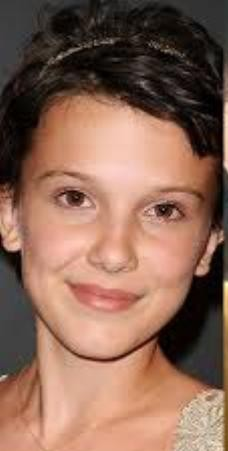

1/1 [==============================] - 1s 599ms/step

Image: 8_1_0_20170117154607954.jpg
 > True Age : 8
 > Predicted Age by Model 1 : 18.3582
 > Predicted Age by Model 2 : 26.1196
 > Predicted Age by Model 3 : 12.4088
 > Predicted Age by Ensembling : 18.9622


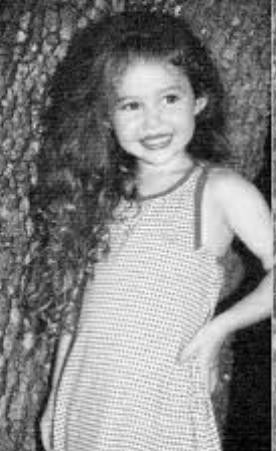

1/1 [==============================] - 1s 606ms/step

Image: 18_0_3_20170116221917954.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 27.5798
 > Predicted Age by Model 2 : 19.0819
 > Predicted Age by Model 3 : 23.2129
 > Predicted Age by Ensembling : 23.2916


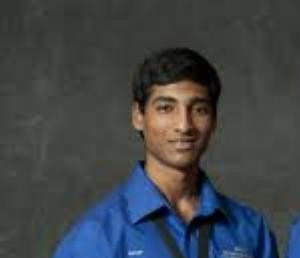

1/1 [==============================] - 1s 1s/step

Image: 18_1_0_20170117133441179.jpg
 > True Age : 18
 > Predicted Age by Model 1 : 25.6188
 > Predicted Age by Model 2 : 12.7404
 > Predicted Age by Model 3 : 13.3092
 > Predicted Age by Ensembling : 17.2228


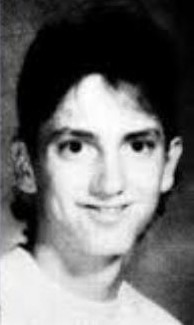

1/1 [==============================] - 1s 748ms/step

Image: 21_1_1_20170116233611534.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 14.0969
 > Predicted Age by Model 2 : 12.0783
 > Predicted Age by Model 3 : 8.7296
 > Predicted Age by Ensembling : 11.6349


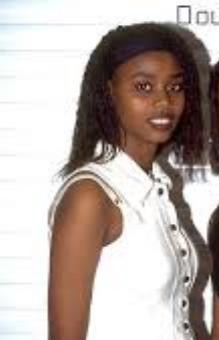

1/1 [==============================] - 1s 575ms/step

Image: 20_1_3_20170119153712943.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 45.1280
 > Predicted Age by Model 2 : 6.6010
 > Predicted Age by Model 3 : 13.3275
 > Predicted Age by Ensembling : 21.6855


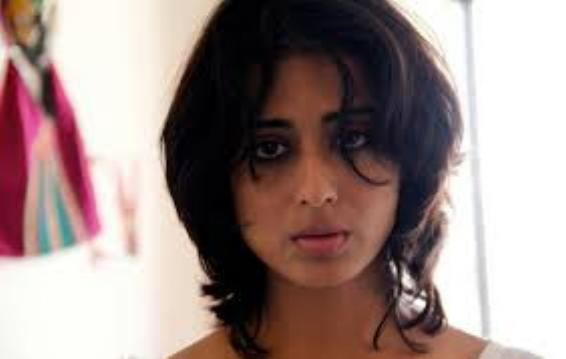

1/1 [==============================] - 1s 598ms/step

Image: 21_0_1_20170116214205175.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 33.7201
 > Predicted Age by Model 2 : 18.4734
 > Predicted Age by Model 3 : 22.0519
 > Predicted Age by Ensembling : 24.7485


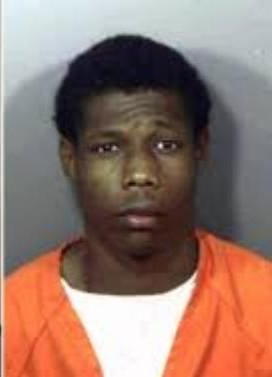

1/1 [==============================] - 1s 596ms/step

Image: 21_0_1_20170115231442487.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 20.0312
 > Predicted Age by Model 2 : 22.8215
 > Predicted Age by Model 3 : 18.8073
 > Predicted Age by Ensembling : 20.5533


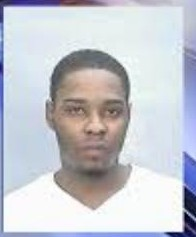

1/1 [==============================] - 1s 595ms/step

Image: 20_1_3_20170119153755113.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 25.8286
 > Predicted Age by Model 2 : 10.3090
 > Predicted Age by Model 3 : 20.5873
 > Predicted Age by Ensembling : 18.9083


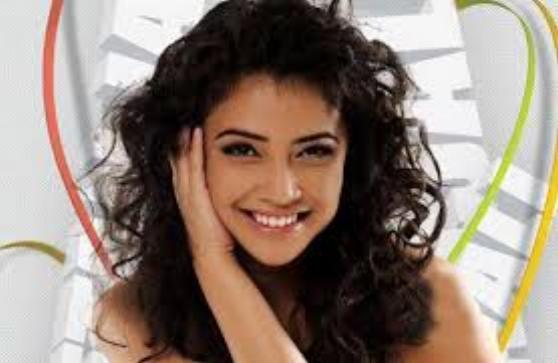

1/1 [==============================] - 1s 890ms/step

Image: 21_1_1_20170117154222282.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 13.1031
 > Predicted Age by Model 2 : 5.9906
 > Predicted Age by Model 3 : 0.0000
 > Predicted Age by Ensembling : 6.3646


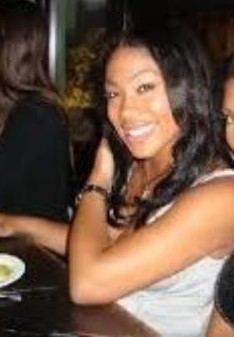

1/1 [==============================] - 1s 1s/step

Image: 15_0_1_20170120134502877.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 16.4554
 > Predicted Age by Model 2 : 20.3880
 > Predicted Age by Model 3 : 17.7612
 > Predicted Age by Ensembling : 18.2015


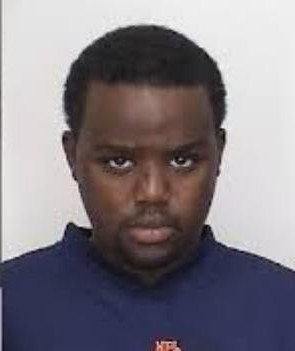

1/1 [==============================] - 1s 1s/step

Image: 4_1_0_20170116215618294.jpg
 > True Age : 4
 > Predicted Age by Model 1 : 32.7045
 > Predicted Age by Model 2 : 5.7973
 > Predicted Age by Model 3 : 36.3319
 > Predicted Age by Ensembling : 24.9446


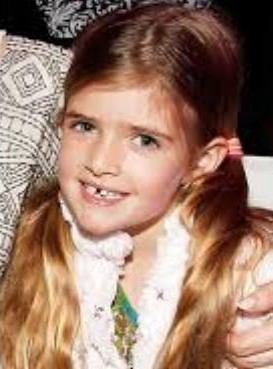

1/1 [==============================] - 1s 1s/step

Image: 16_1_0_20170117133441179.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 23.5621
 > Predicted Age by Model 2 : 10.6117
 > Predicted Age by Model 3 : 15.4725
 > Predicted Age by Ensembling : 16.5487


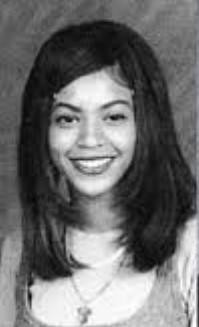

1/1 [==============================] - 1s 1s/step

Image: 17_0_0_20170116221917954.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 29.7642
 > Predicted Age by Model 2 : 13.2104
 > Predicted Age by Model 3 : 12.1768
 > Predicted Age by Ensembling : 18.3838


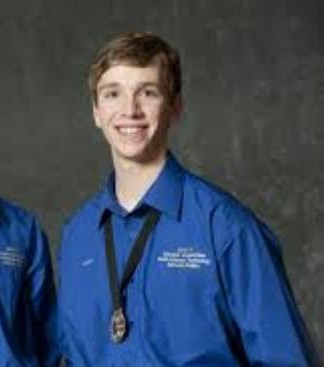

1/1 [==============================] - 1s 1s/step

Image: 16_0_1_20170116161243731.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 43.9903
 > Predicted Age by Model 2 : 12.3829
 > Predicted Age by Model 3 : 25.3791
 > Predicted Age by Ensembling : 27.2508


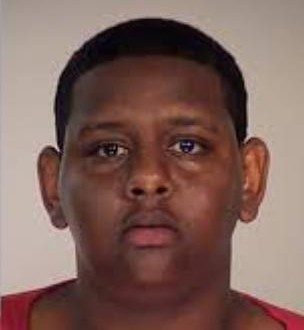

1/1 [==============================] - 1s 602ms/step

Image: 20_1_1_20170116003433569.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 24.3273
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 14.7755
 > Predicted Age by Ensembling : 13.0343


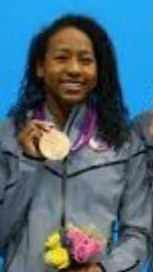

1/1 [==============================] - 1s 588ms/step

Image: 10_0_0_20170116201102149.jpg
 > True Age : 10
 > Predicted Age by Model 1 : 5.3661
 > Predicted Age by Model 2 : 8.2287
 > Predicted Age by Model 3 : 21.5827
 > Predicted Age by Ensembling : 11.7259


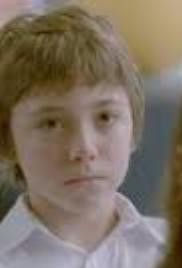

1/1 [==============================] - 1s 582ms/step

Image: 11_1_0_20170117133441179.jpg
 > True Age : 11
 > Predicted Age by Model 1 : 20.4926
 > Predicted Age by Model 2 : 12.5612
 > Predicted Age by Model 3 : 18.0751
 > Predicted Age by Ensembling : 17.0430


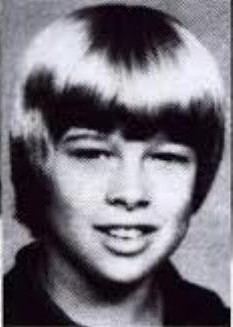

1/1 [==============================] - 1s 993ms/step

Image: 17_1_3_20170119153627673.jpg
 > True Age : 17
 > Predicted Age by Model 1 : 16.7023
 > Predicted Age by Model 2 : 20.4807
 > Predicted Age by Model 3 : 18.6225
 > Predicted Age by Ensembling : 18.6018


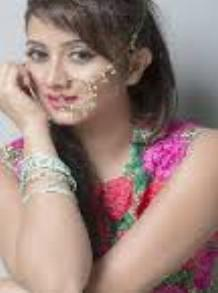

1/1 [==============================] - 1s 970ms/step

Image: 5_1_3_20170119154358954.jpg
 > True Age : 5
 > Predicted Age by Model 1 : 28.5338
 > Predicted Age by Model 2 : 3.2597
 > Predicted Age by Model 3 : 9.1678
 > Predicted Age by Ensembling : 13.6538


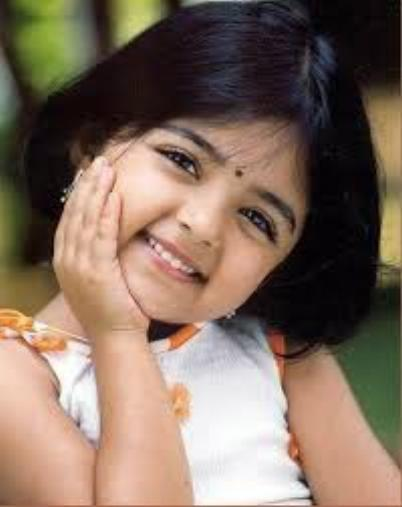

1/1 [==============================] - 1s 607ms/step

Image: 16_1_0_20170119155149354.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 23.8632
 > Predicted Age by Model 2 : 16.1167
 > Predicted Age by Model 3 : 12.8611
 > Predicted Age by Ensembling : 17.6137


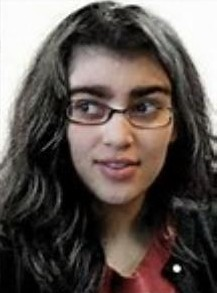

1/1 [==============================] - 1s 602ms/step

Image: 21_0_3_20170119150216454.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 24.8380
 > Predicted Age by Model 2 : 23.9831
 > Predicted Age by Model 3 : 15.1264
 > Predicted Age by Ensembling : 21.3158


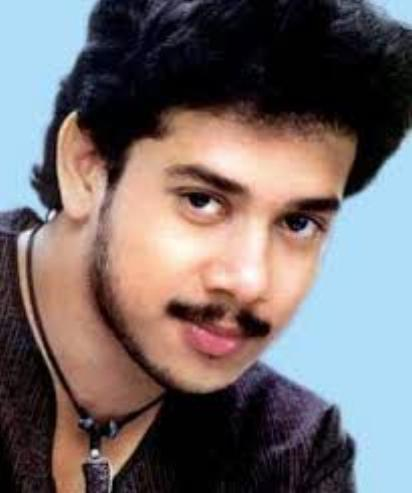

1/1 [==============================] - 1s 593ms/step

Image: 20_1_3_20170119153750257.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 23.6383
 > Predicted Age by Model 2 : 13.2004
 > Predicted Age by Model 3 : 32.1052
 > Predicted Age by Ensembling : 22.9813


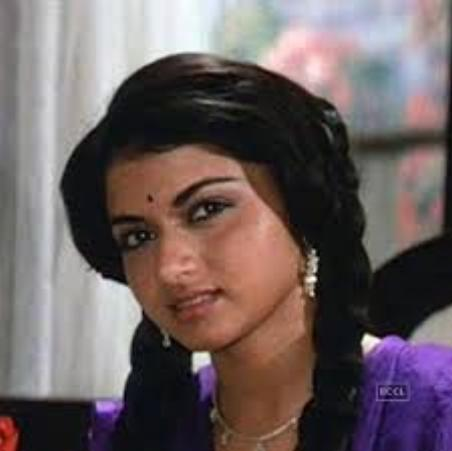

1/1 [==============================] - 1s 605ms/step

Image: 20_1_0_20170119153717575.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 23.9690
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 21.4959
 > Predicted Age by Ensembling : 15.1550


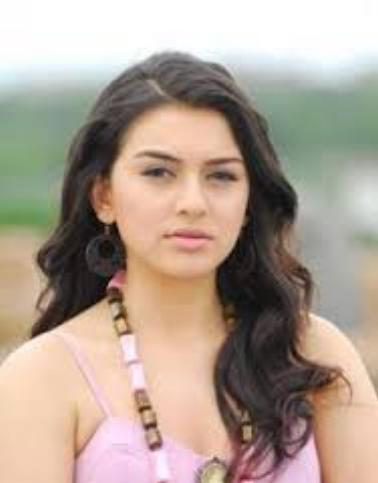

1/1 [==============================] - 1s 846ms/step

Image: 20_1_1_20170116003433569.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 24.3273
 > Predicted Age by Model 2 : 0.0000
 > Predicted Age by Model 3 : 14.7755
 > Predicted Age by Ensembling : 13.0343


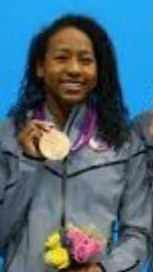

1/1 [==============================] - 1s 947ms/step

Image: 15_1_0_20170116232438243.jpg
 > True Age : 15
 > Predicted Age by Model 1 : 18.4518
 > Predicted Age by Model 2 : 25.5183
 > Predicted Age by Model 3 : 28.6537
 > Predicted Age by Ensembling : 24.2079


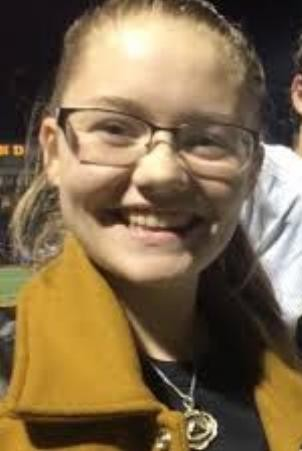

1/1 [==============================] - 1s 591ms/step

Image: 20_1_1_20170116162433766.jpg
 > True Age : 20
 > Predicted Age by Model 1 : 30.8962
 > Predicted Age by Model 2 : 16.4326
 > Predicted Age by Model 3 : 25.6702
 > Predicted Age by Ensembling : 24.3330


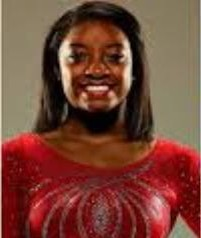

1/1 [==============================] - 1s 584ms/step

Image: 14_0_1_20170116205011065.jpg
 > True Age : 14
 > Predicted Age by Model 1 : 22.8283
 > Predicted Age by Model 2 : 5.8684
 > Predicted Age by Model 3 : 8.3542
 > Predicted Age by Ensembling : 12.3503


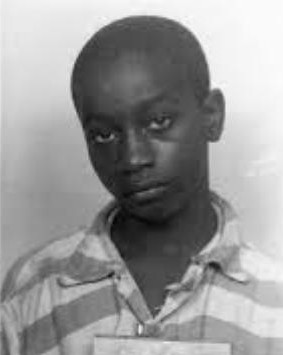

1/1 [==============================] - 1s 583ms/step

Image: 21_1_1_20170116214444631.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 21.3771
 > Predicted Age by Model 2 : 22.0200
 > Predicted Age by Model 3 : 18.4166
 > Predicted Age by Ensembling : 20.6046


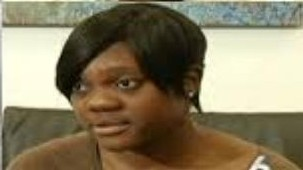

1/1 [==============================] - 1s 597ms/step

Image: 21_0_0_20170116225141614.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 18.5023
 > Predicted Age by Model 2 : 3.8606
 > Predicted Age by Model 3 : 19.8893
 > Predicted Age by Ensembling : 14.0841


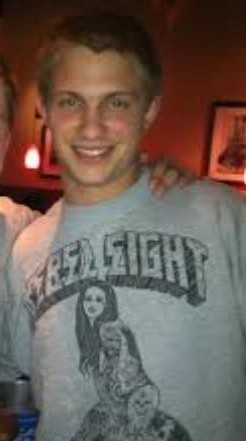

1/1 [==============================] - 1s 582ms/step

Image: 16_0_1_20170116214205175.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 32.2200
 > Predicted Age by Model 2 : 13.7117
 > Predicted Age by Model 3 : 10.9172
 > Predicted Age by Ensembling : 18.9497


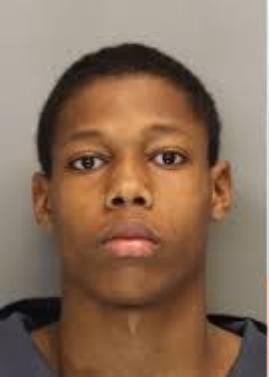

1/1 [==============================] - 1s 1s/step

Image: 16_0_1_20170120134502877.jpg
 > True Age : 16
 > Predicted Age by Model 1 : 37.4831
 > Predicted Age by Model 2 : 3.1142
 > Predicted Age by Model 3 : 28.7357
 > Predicted Age by Ensembling : 23.1110


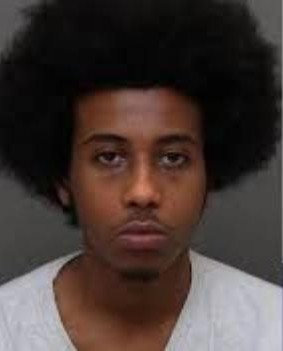

1/1 [==============================] - 1s 594ms/step

Image: 21_0_3_20170119150216454.jpg
 > True Age : 21
 > Predicted Age by Model 1 : 24.8380
 > Predicted Age by Model 2 : 23.9831
 > Predicted Age by Model 3 : 15.1264
 > Predicted Age by Ensembling : 21.3158


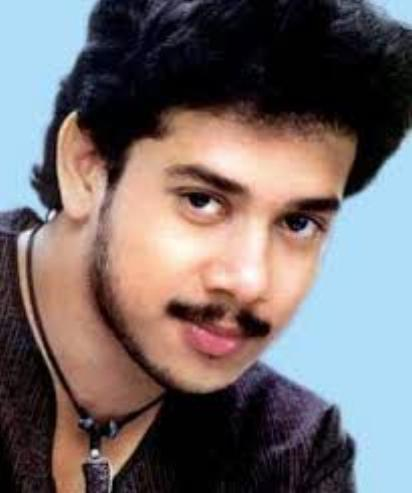


Accuracy: 0.5845070422535211


In [20]:
import os
import numpy as np
from IPython.display import display, Image

# Test on 10 random images from validation set
random_choices = list(np.random.choice(image_paths_val, 142))  # Choose 10 random images
ensemble_predictions = {}
threshold = 5  # Umbral de tolerancia de 5 años

correct_predictions = 0

for image_path in random_choices:
    test_image, _ = preprocess([image_path])  # Preprocess image
    predictions = {}
    for model_name, model in ensemble_models.items():
        prediction = model.predict(test_image)
        predictions[model_name] = prediction
    true_age = int(image_path.split('_')[0])
    ensemble_avg_prediction = 0
    print("\nImage:", image_path)
    print(' > True Age : {}'.format(true_age))
    for model_name, prediction in predictions.items():
        predicted_age = prediction[0][0]
        print(' > Predicted Age by {0} : {1:.4f}'.format(model_name, predicted_age))
        ensemble_avg_prediction += predicted_age
    ensemble_avg_prediction /= n_models
    print(' > Predicted Age by Ensembling : {0:.4f}'.format(ensemble_avg_prediction))
    ensemble_predictions[image_path] = ensemble_avg_prediction

    # Calcular si la predicción es correcta o no
    if abs(ensemble_avg_prediction - true_age) <= threshold:
        correct_predictions += 1

    # Mostrar la imagen correspondiente
    display(Image(filename=os.path.join(imgs_folder_path, image_path), width=200, height=200))

accuracy = correct_predictions / len(random_choices)
print("\nAccuracy:", accuracy)



	==> Model 1
Directory model_data/Model 1 already exists. Skipping creation...


<ipython-input-21-b7acc7ea1a79>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator_train,


Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 11.8973 
Epoch 1: val_loss improved from inf to 7.04822, saving model to model_data/Model 1/epoch-01_loss-11.8973_val_loss-7.0482.h5
2/2 [==============================] - 89s 68s/step - loss: 11.8973 - val_loss: 7.0482
Epoch 2/2
2/2 [==============================] - ETA: 0s - loss: 13.4131
Epoch 2: val_loss improved from 7.04822 to 6.66187, saving model to model_data/Model 1/epoch-02_loss-13.4131_val_loss-6.6619.h5
2/2 [==============================] - 51s 47s/step - loss: 13.4131 - val_loss: 6.6619

	==> Model 2
Directory model_data/Model 2 already exists. Skipping creation...
Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 12.5011 
Epoch 1: val_loss improved from inf to 13.64286, saving model to model_data/Model 2/epoch-01_loss-12.5011_val_loss-13.6429.h5
2/2 [==============================] - 126s 104s/step - loss: 12.5011 - val_loss: 13.6429
Epoch 2/2
2/2 [==============================] - ETA: 0s 

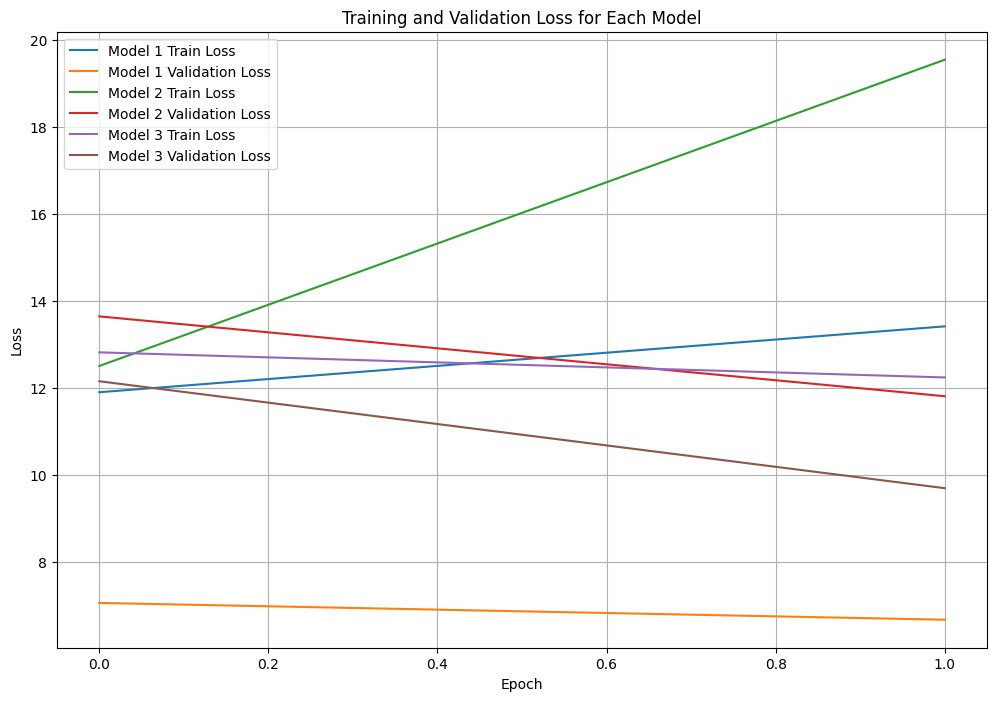

In [21]:
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Definir listas para almacenar las pérdidas de entrenamiento y validación para cada modelo
loss_train_per_model = []
loss_valid_per_model = []

# Entrenamiento de los modelos y cálculo de la precisión
for model_number in range(n_models):
    model = None
    name = 'Model ' + str(model_number+1)
    print("\n\t==>", name)

    # Generar generadores de lotes para entrenamiento y validación
    generator_train = batch_generator(image_paths_train, batch_size=batch_size, seed=model_number+1)
    generator_val = batch_generator(image_paths_val, batch_size=batch_size, seed=model_number+1)

    # Crear directorio para guardar los checkpoints del modelo
    base_path = os.path.join('model_data', name)
    try:
        os.makedirs(base_path)
    except FileExistsError:
        print('Directory {} already exists. Skipping creation...'.format(base_path))

    # Configurar punto de control para guardar el mejor modelo
    checkpoint = ModelCheckpoint(filepath=os.path.join(base_path,'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

    # Compilar y entrenar el modelo
    callbacks = [checkpoint]
    model = get_model(train_last_layers=1)
    history = model.fit_generator(generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=len(image_paths_train)//batch_size,
                                  validation_data=generator_val,
                                  validation_steps=len(image_paths_val)//batch_size,
                                  callbacks=callbacks,
                                  verbose=1)

    # Guardar las pérdidas de entrenamiento y validación en listas separadas
    loss_train_per_model.append(history.history['loss'])
    loss_valid_per_model.append(history.history['val_loss'])

# Graficar el histograma de pérdida para cada modelo
plt.figure(figsize=(12, 8))
for model_number in range(n_models):
    plt.plot(range(epochs), loss_train_per_model[model_number], label='Model {} Train Loss'.format(model_number + 1))
    plt.plot(range(epochs), loss_valid_per_model[model_number], label='Model {} Validation Loss'.format(model_number + 1))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Each Model')
plt.legend()
plt.grid(True)
plt.show()
